# Exploring DNN Fits

## Configuration

In [1]:
import sys
sys.path.extend(['..', '../bprime'])

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import re
from collections import defaultdict
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import itertools

from bprime.learn import LearnedFunction, LearnedB
from bprime.theory import bgs_segment, bgs_rec
from bprime.plots import bhat_plot, loss_plot, loss_limits_plot, rate_loss_plot
from bprime.plots import b_learn_diagnostic_plot, rate_plot, arch_loss_plot, rate_density_plot
from bprime.plots import B_loss_plot, feature_loss_plot, feature_loss_plots, theory_loss_plot, rf_plot
from bprime.nb_utils import load_learnedfuncs_in_dir
from bprime.utils import signif

#os.environ["CUDA_VISIBLE_DEVICES"]="1,1"

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 300
plt.style.use('./buffalo.mplstyle')

In [4]:
FIT_DIR = '../data/msprime_sims/fits/'

models = [f for f in os.listdir(FIT_DIR) if not f.startswith('varying')]
#models = ['segment_uniform_mu']
res = {m: load_learnedfuncs_in_dir(os.path.join(FIT_DIR, m)) for m in models}

res.keys()

2022-04-25 20:37:49.873358: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 20:37:52.502892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5965 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-04-25 20:37:52.504280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6654 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-04-25 20:37:52.505226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica

dict_keys(['segment_logL_logrbp_logrf_wide_reject', 'segment_logL_logrbp_logrf_wide_reject_replicated', 'segment_logL_logrbp_logrf_wide', 'simple', 'simple_varlogL', 'segment_logL_logrbp_logrf', 'simple_varL', 'simple_varlogL_varrbp'])

Todo

- smaller arch input size
 - different loss
 - downloading to uniform on B 
 - train past stopping point to see if val

## Simple BGS model

First we look at the simple BGS model, which just includes the total fixed recombination fraction. This is the same as `bgs_rec()` in the `bprime.theory` module.

The model is:

$$B_\mathrm{rec} = \exp\left({\frac{-\mu L}{(t(1+(1-t)r_\mathrm{BP}/t)^2)}}\right)$$

where $t = sh$.

### Variable $\mu$ and $t$

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


(<Figure size 2700x750 with 3 Axes>,
 <AxesSubplot:title={'center':'n128=0, n64=0, n32=4, n8=2, n2=0'}>)

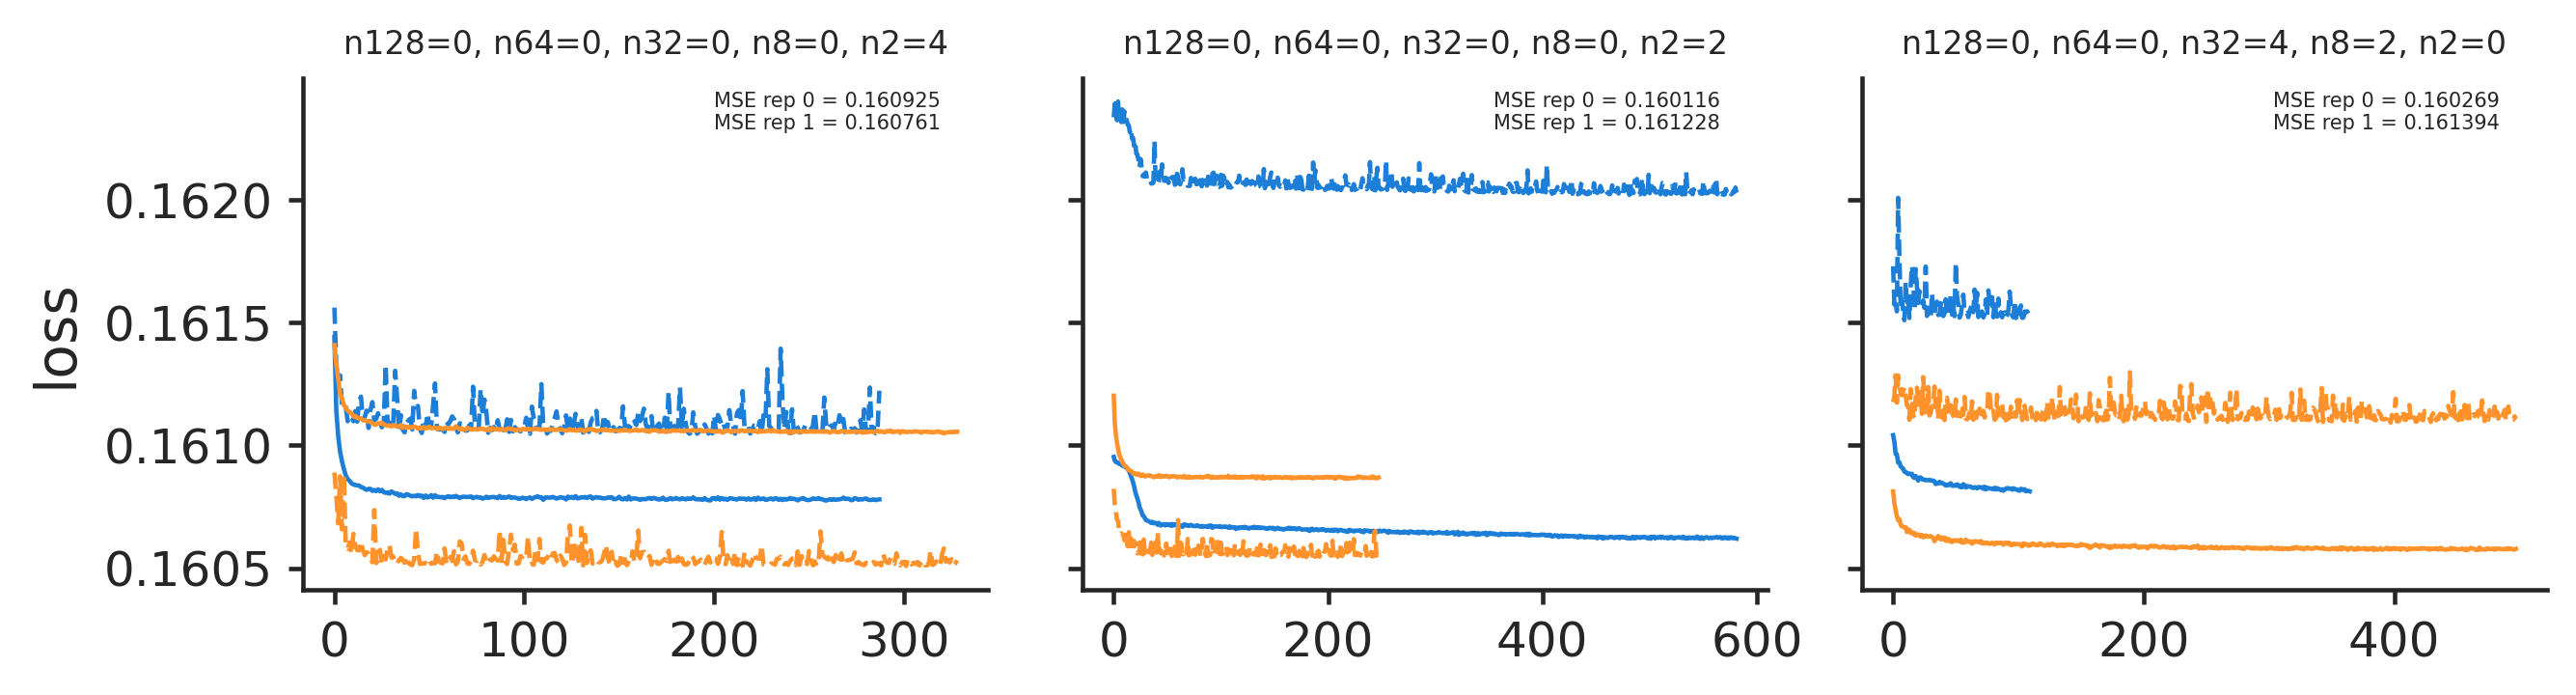

In [9]:
arch_loss_plot(res['simple'])

n2 = {2, 4} does well here — things work well if the number of neurons per layer is the input size. 

In [13]:
ARCH = (0, 0, 0, 0, 2)

making 100x100 grid...	done.
313/313 [==============================] - 0s 1ms/step


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


(<Figure size 3000x2100 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:title={'center':'\ntheory MAE=0.001115, MSE=2.23e-06'}, ylabel='theory'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

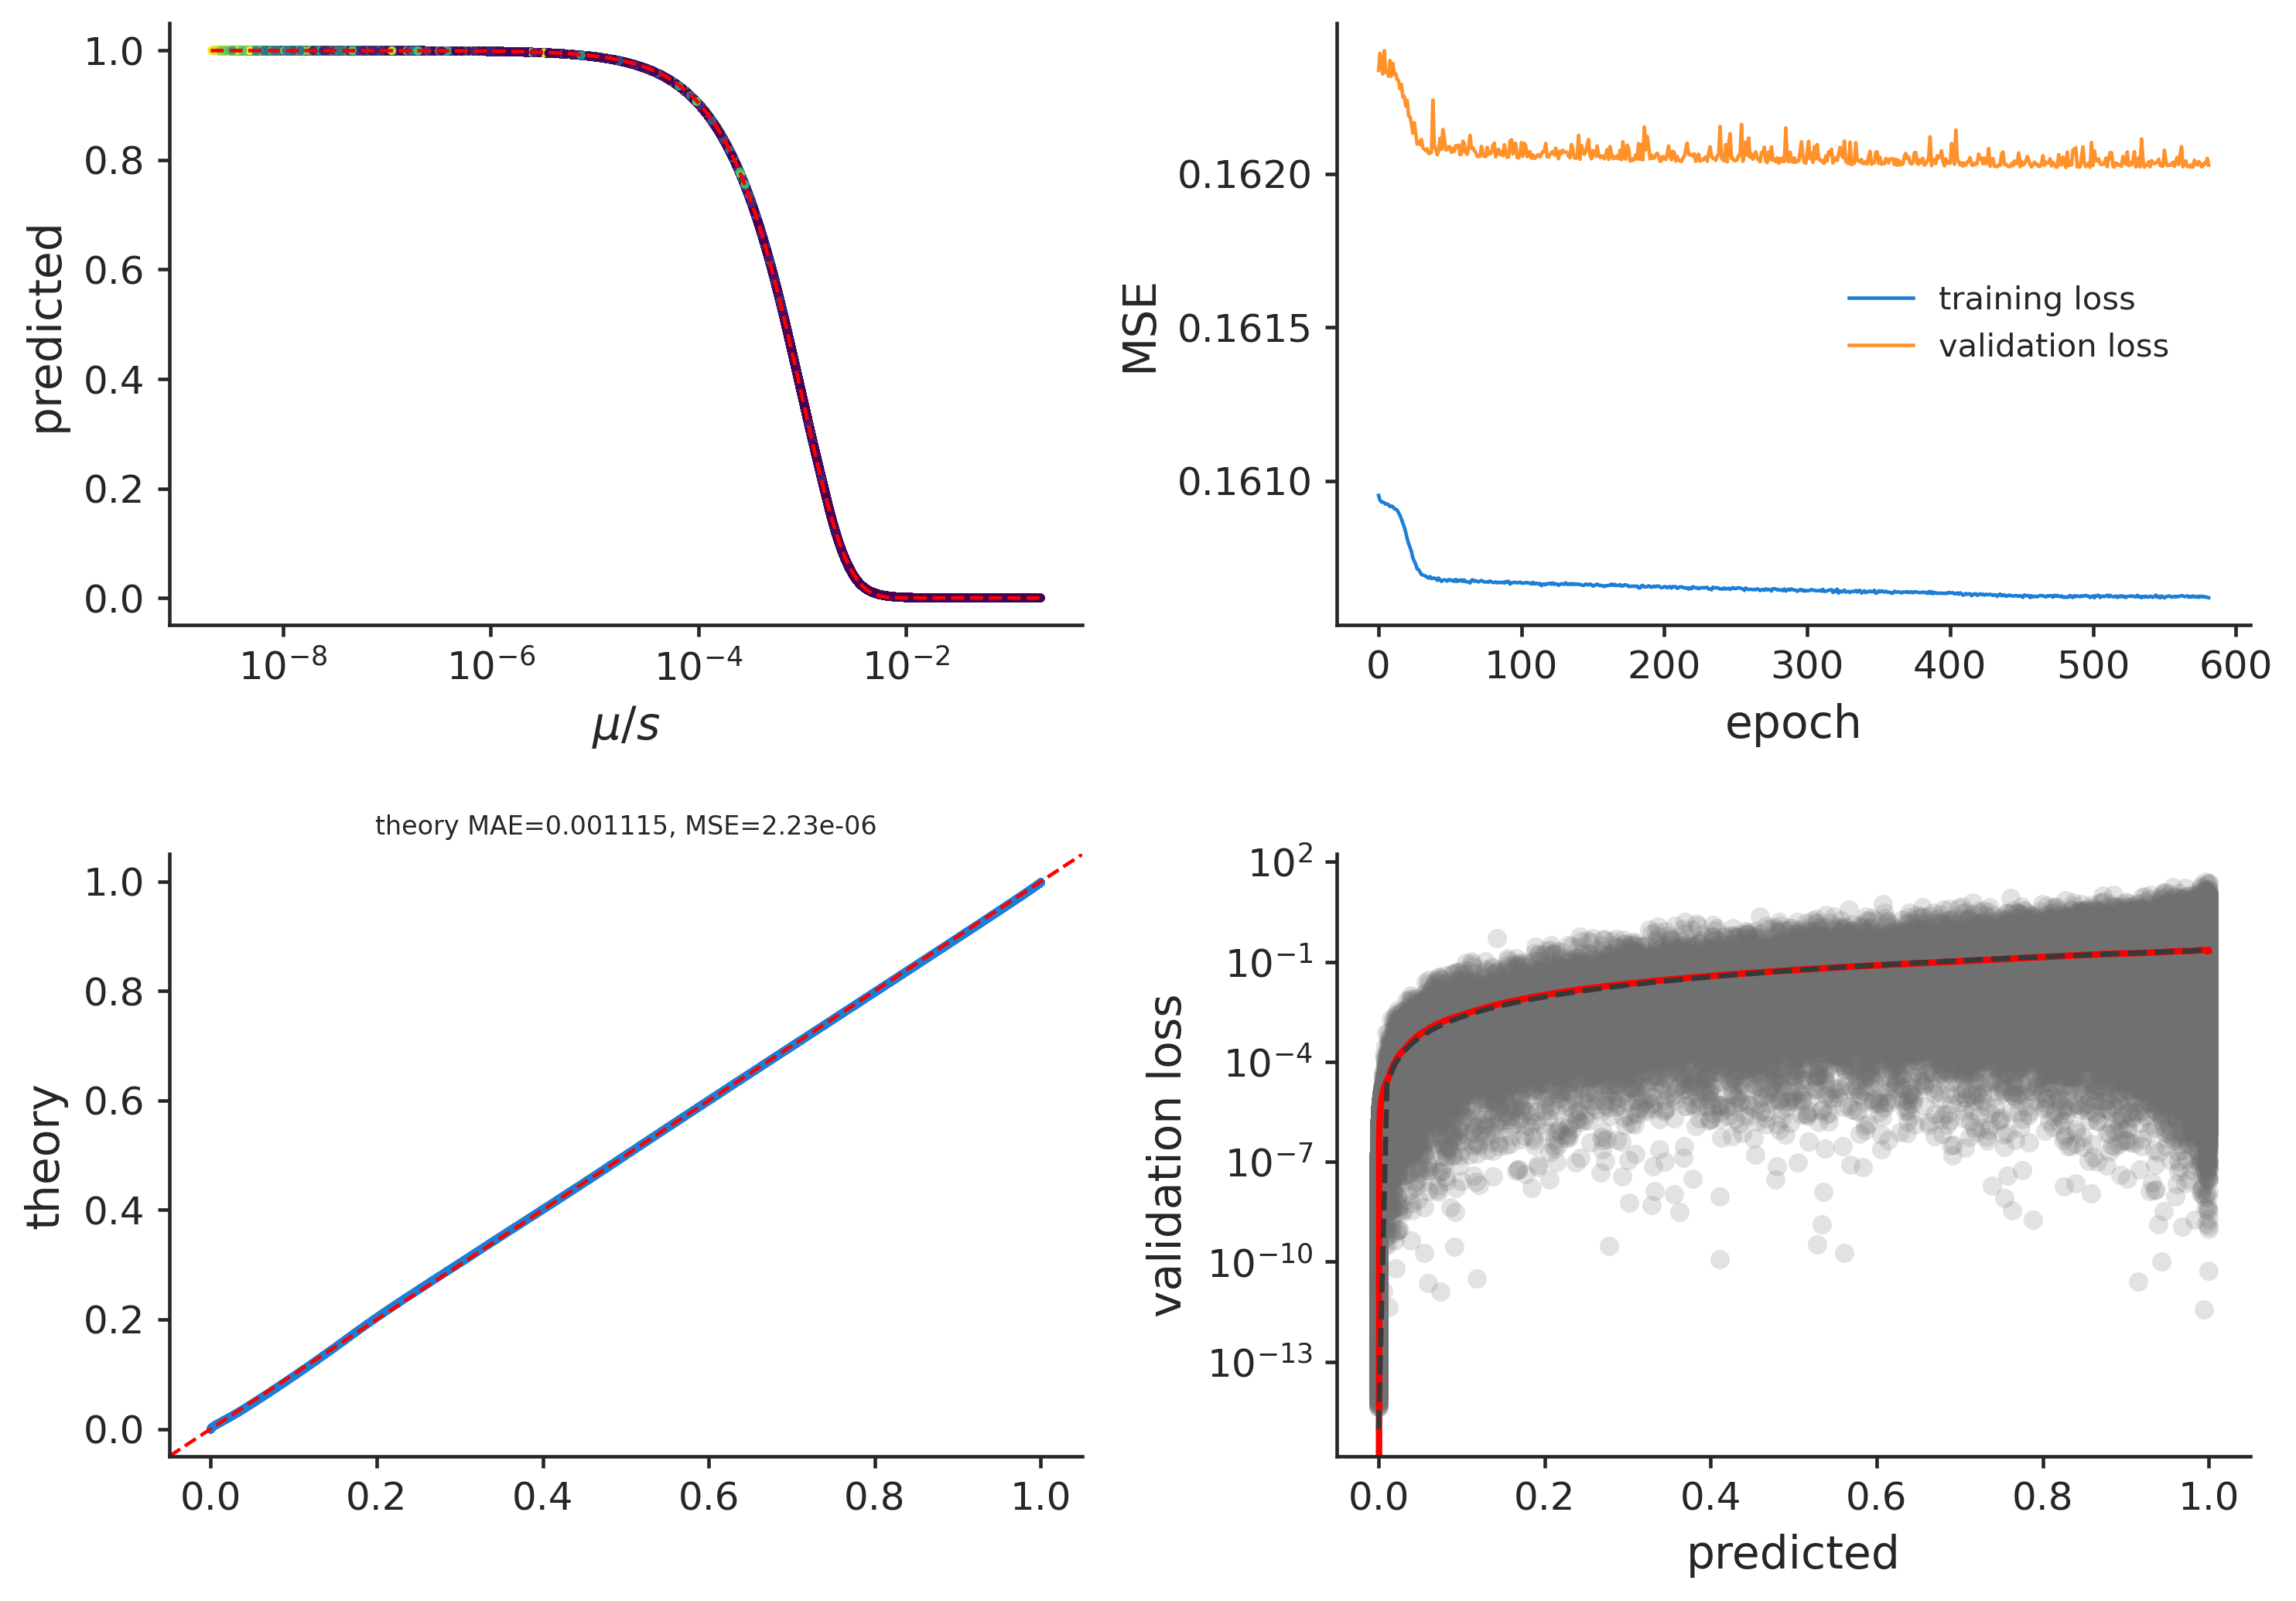

In [15]:
b_learn_diagnostic_plot(res['simple'][ARCH][0], n={'mu': 100, 'sh': 100}, c='sh')

(<Figure size 2400x1200 with 2 Axes>,
 array([<AxesSubplot:xlabel='$\\mu/s$', ylabel='density'>,
        <AxesSubplot:xlabel='$B_\\mathrm{theory}$', ylabel='density'>],
       dtype=object))

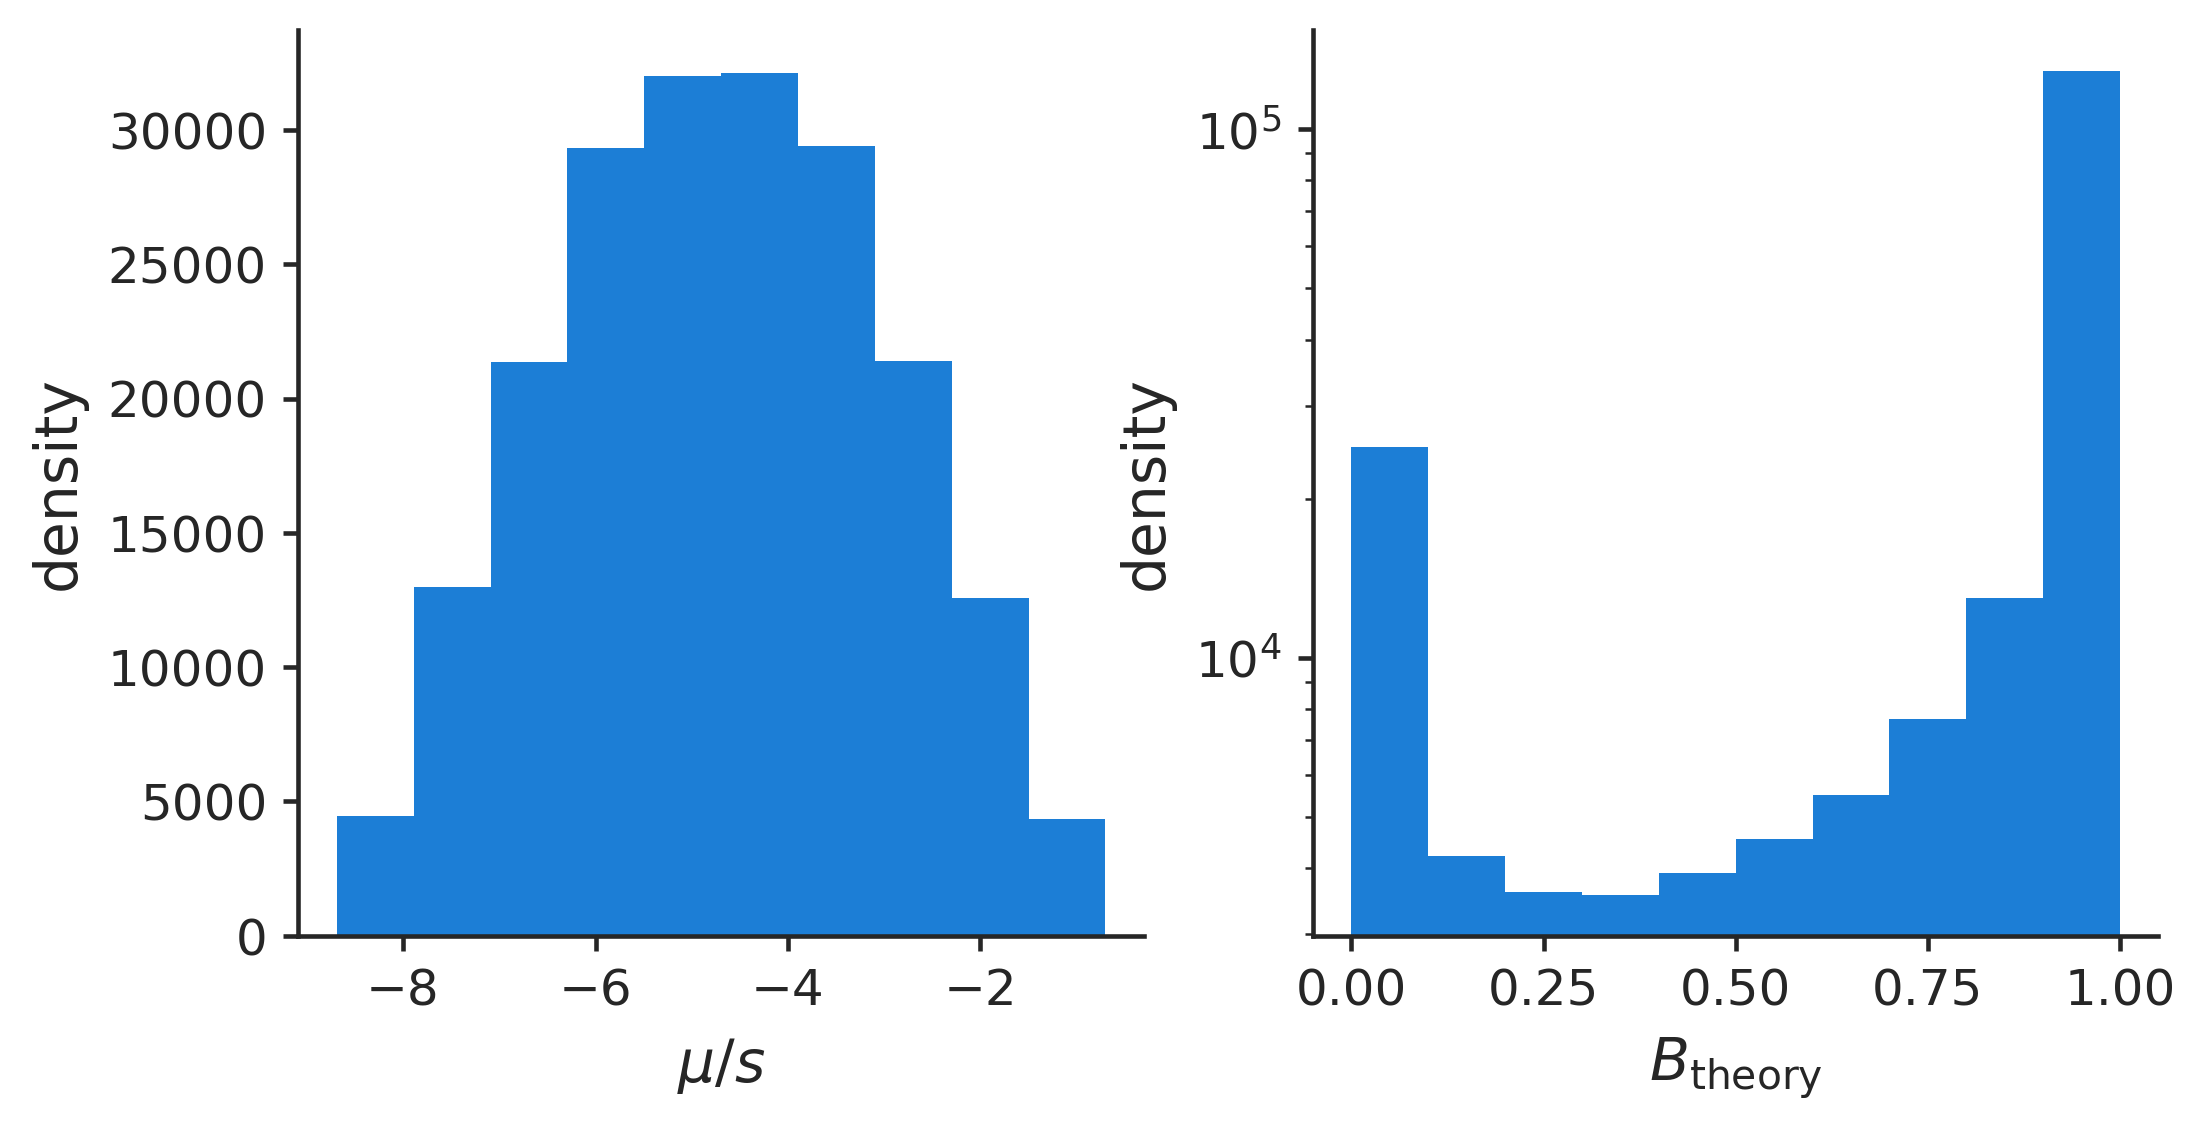

In [16]:
rate_density_plot(res['simple'][ARCH][0])

### Variable $\mu$, $t$, and $L$ — $\mu$ and $t$ Log-scaled, $L$ Linear

In [17]:
ARCH = (0, 0, 0, 0, 2)

In [18]:
res['simple_varL'][ARCH][0].func

LearnedFunction with 3 feature(s)
 variable feature(s):
  - L ∈ [0.0, 1000] (linear, None)
  - mu ∈ [-10, -5] (log10, <ufunc 'log10'>)
  - sh ∈ [-4.3, -1.3] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
  - N = 1000
  - rbp = 1e-08
Features normalized? True
Features split? True, test size: 20.0% (n=200,000)
Total size: 1,000,000

(<Figure size 2700x750 with 3 Axes>,
 <AxesSubplot:title={'center':'n128=0, n64=0, n32=4, n8=2, n3=0'}>)

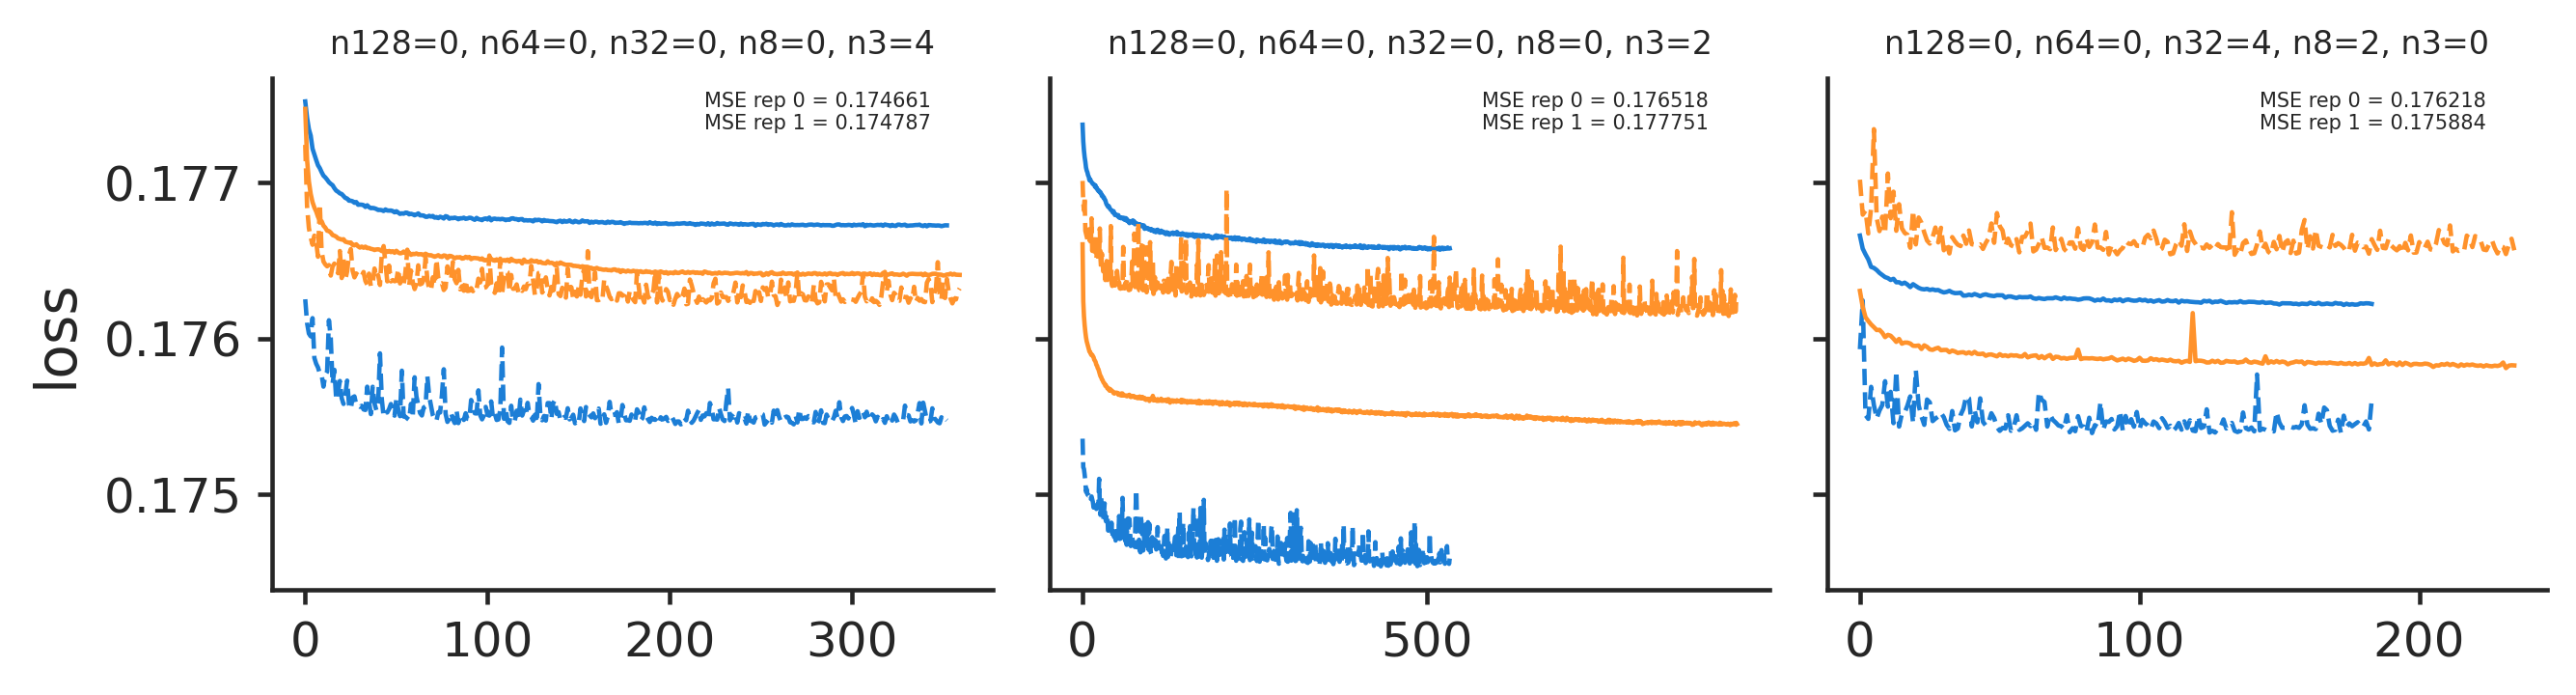

In [19]:
arch_loss_plot(res['simple_varL'])

(<Figure size 3000x2100 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:title={'center':'\ntheory MAE=0.003258, MSE=8.4e-05'}, ylabel='theory'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

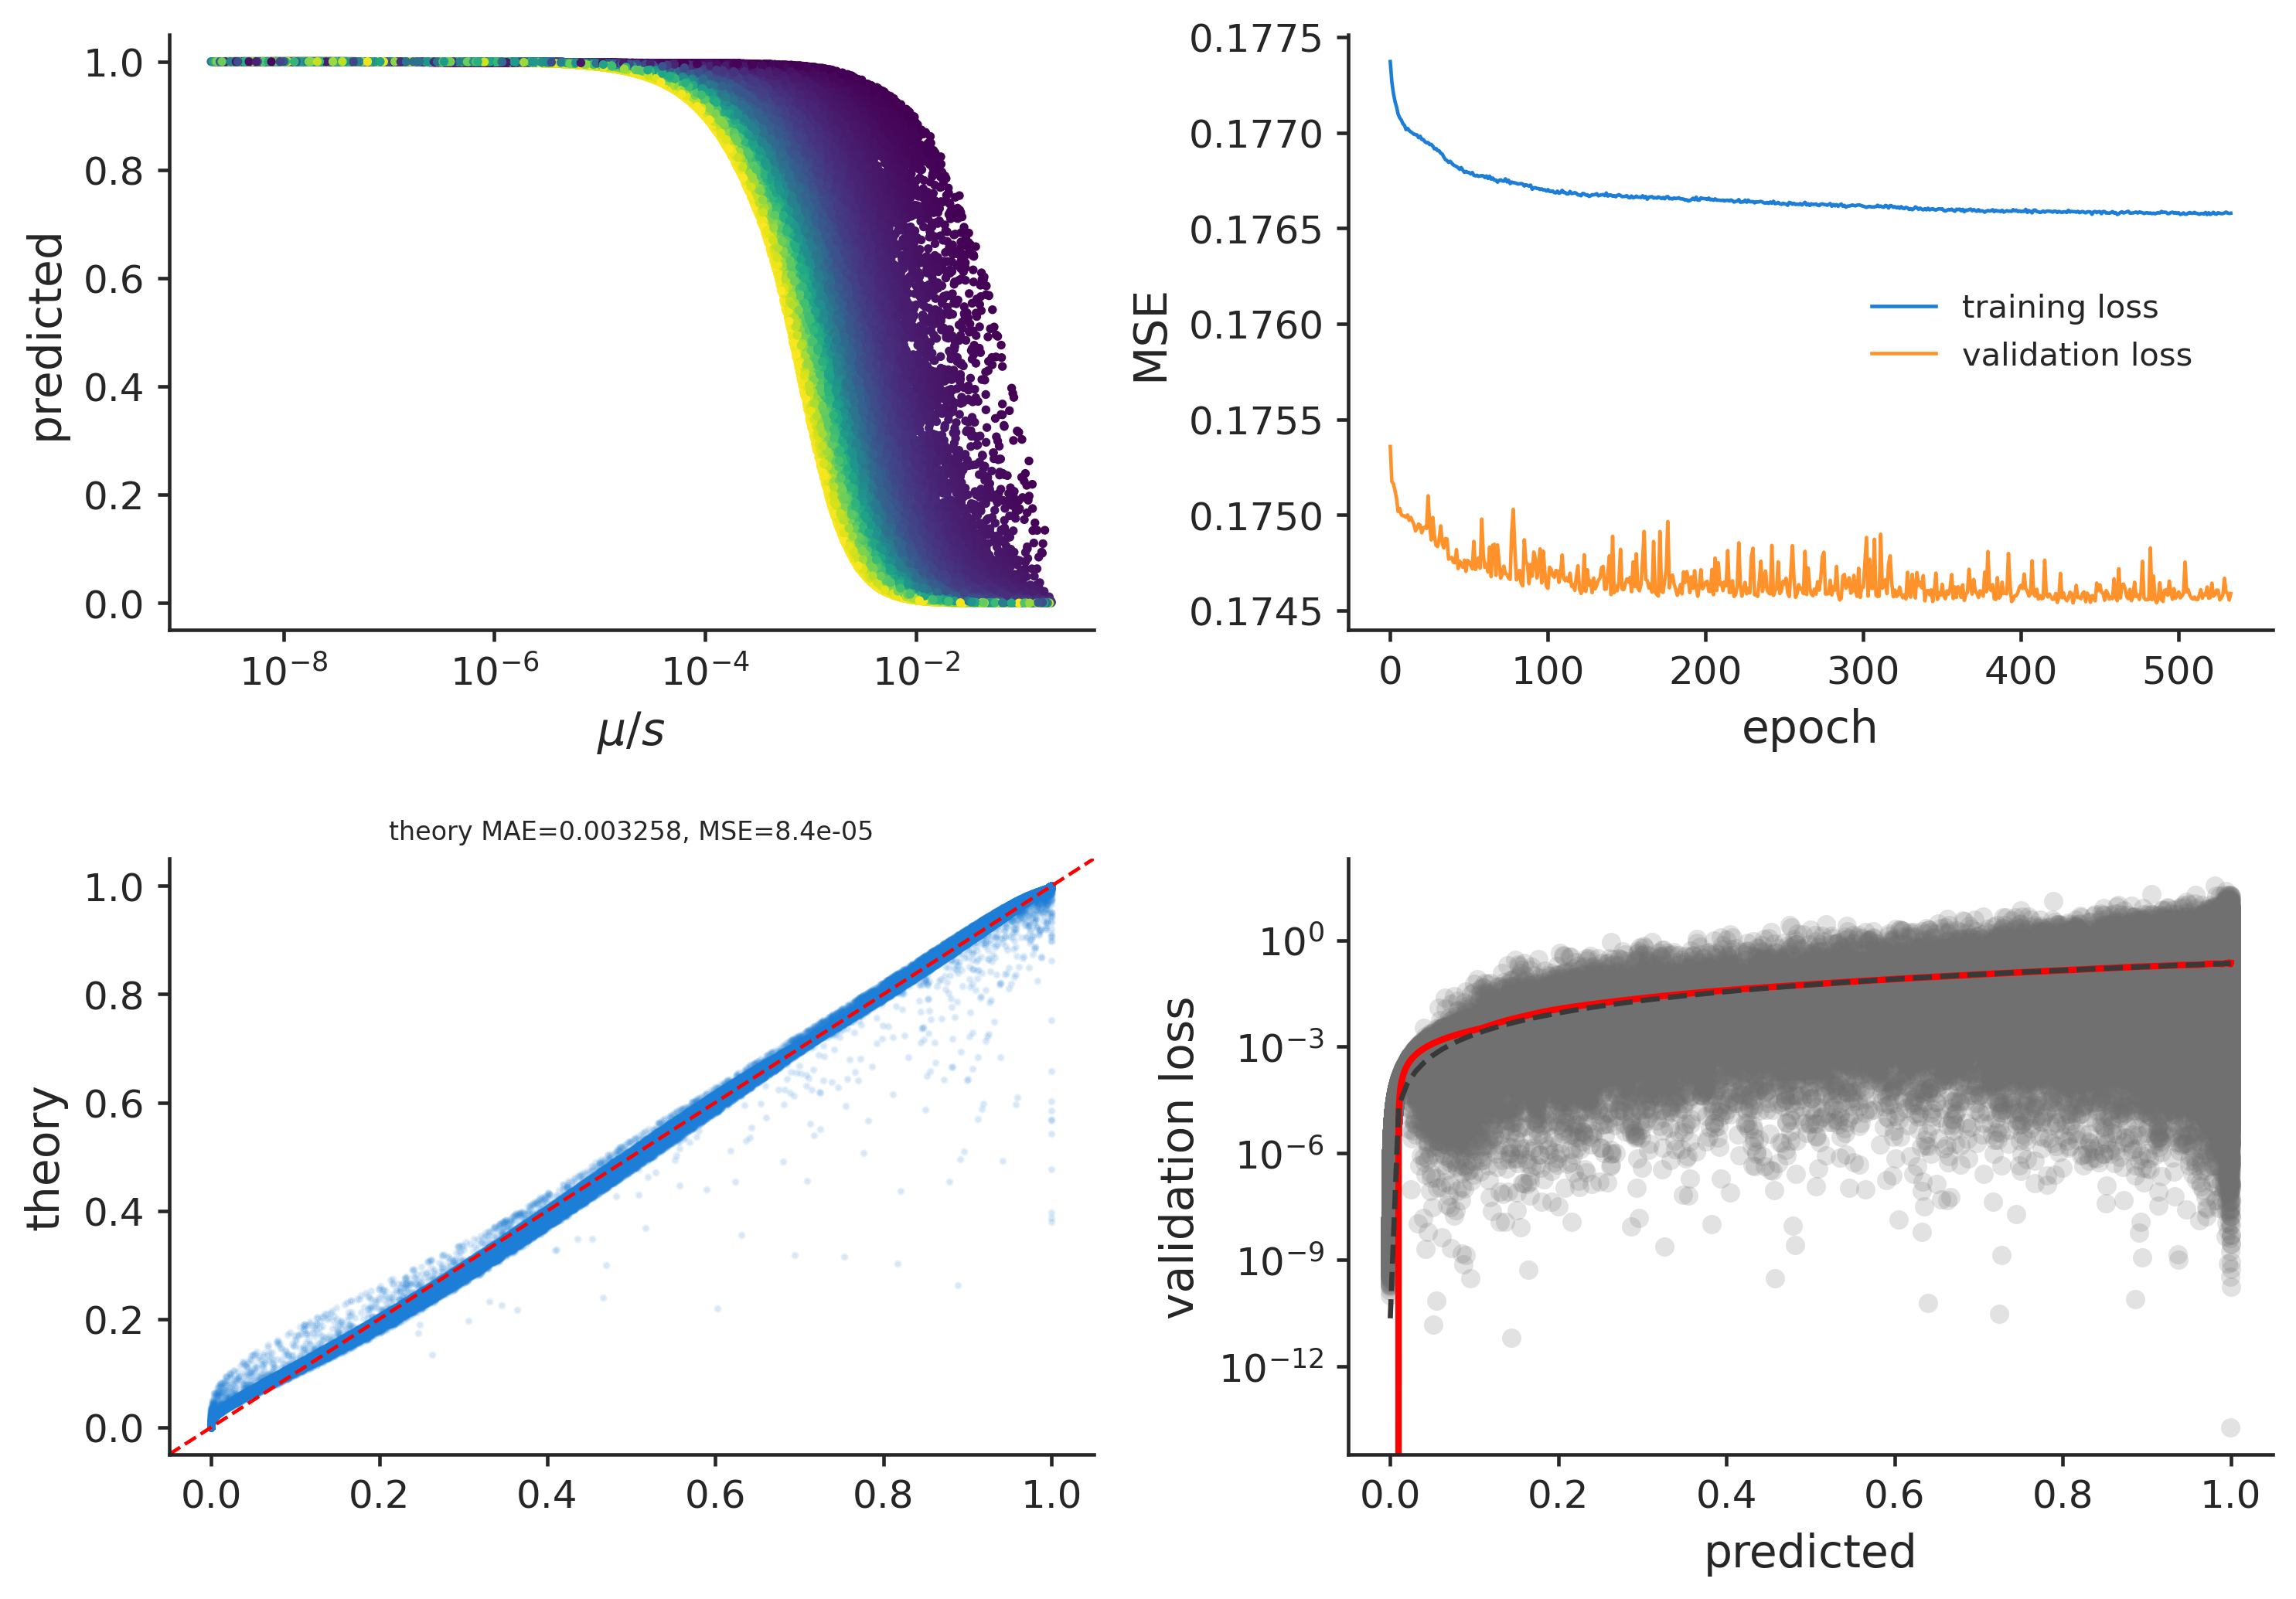

In [20]:
b_learn_diagnostic_plot(res['simple_varL'][ARCH][0], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10}, c='L', add_theory=False)

### Variable $\mu$, $t$, and $L$ — $\mu$, $t$, and $L$ Log-scaled

In [22]:
res['simple_varlogL'][ARCH][0].func

LearnedFunction with 3 feature(s)
 variable feature(s):
  - mu ∈ [-10, -5] (log10, <ufunc 'log10'>)
  - sh ∈ [-4.3, -1.3] (log10, <ufunc 'log10'>)
  - L ∈ [-1, 3.04] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
  - N = 1000
  - rbp = 1e-08
Features normalized? True
Features split? True, test size: 20.0% (n=200,000)
Total size: 1,000,000

(<Figure size 2700x750 with 3 Axes>,
 <AxesSubplot:title={'center':'n128=0, n64=0, n32=4, n8=2, n3=0'}>)

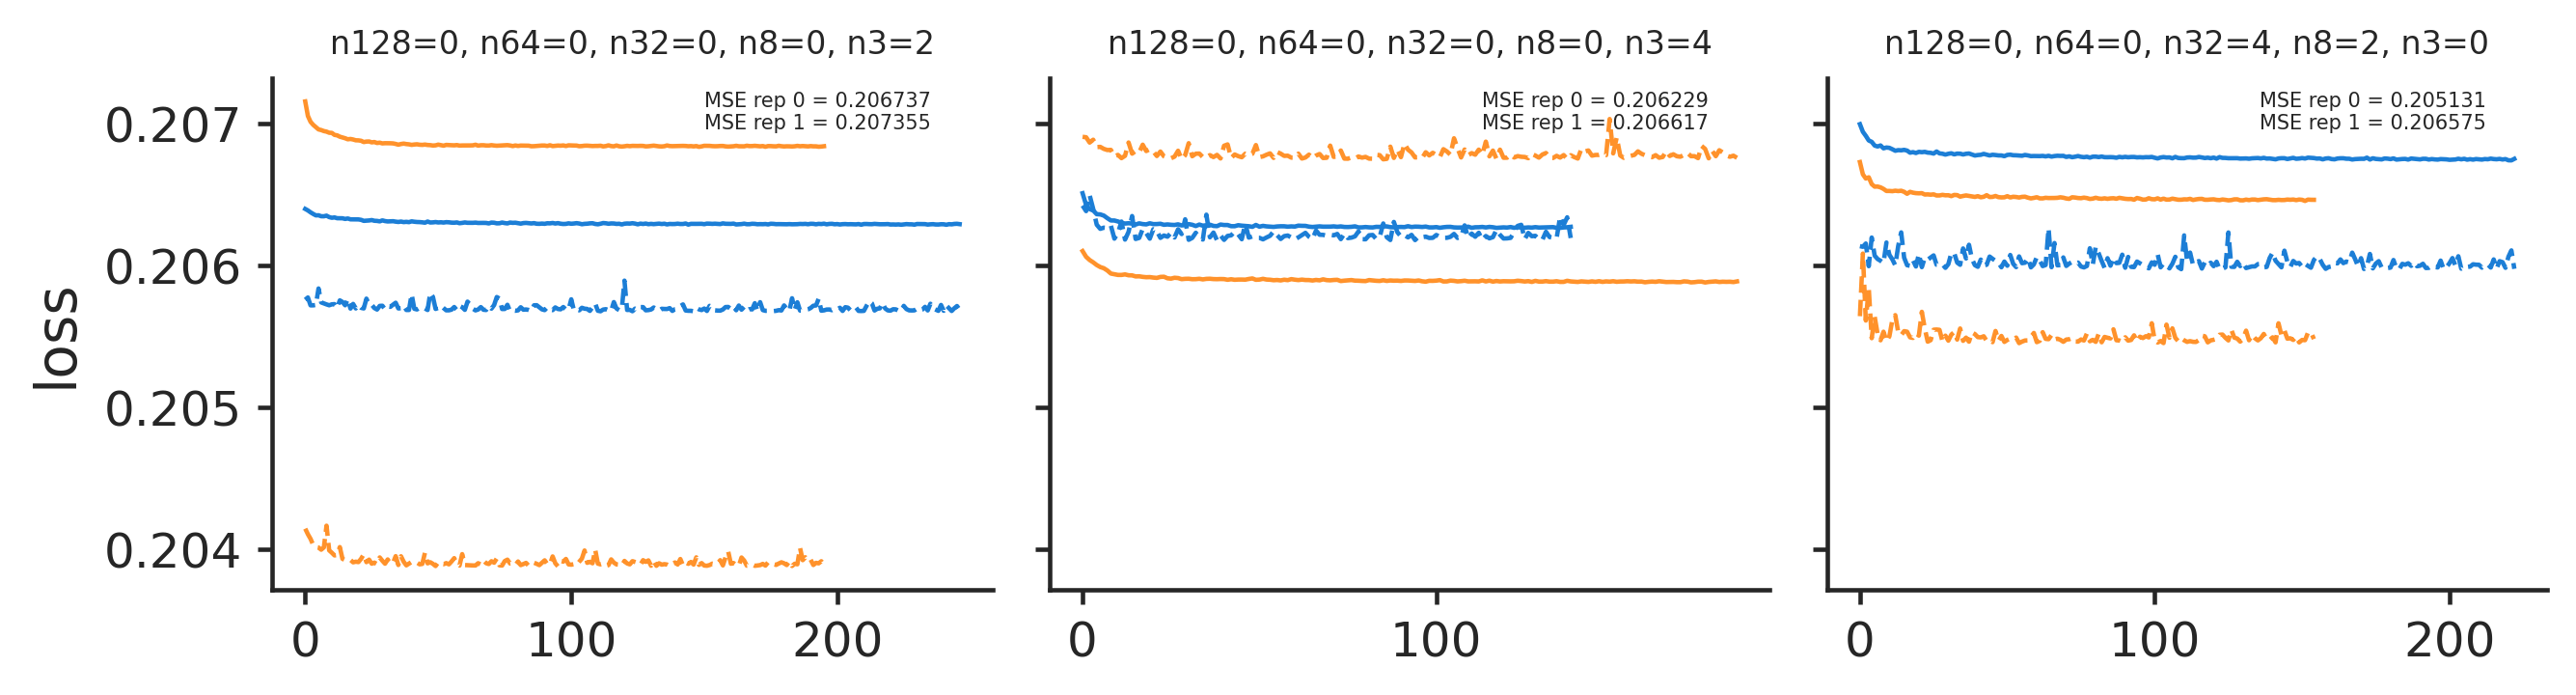

In [23]:
arch_loss_plot(res['simple_varlogL'])

(<Figure size 3000x2100 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:title={'center':'\ntheory MAE=0.001089, MSE=2.33e-06'}, ylabel='theory'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

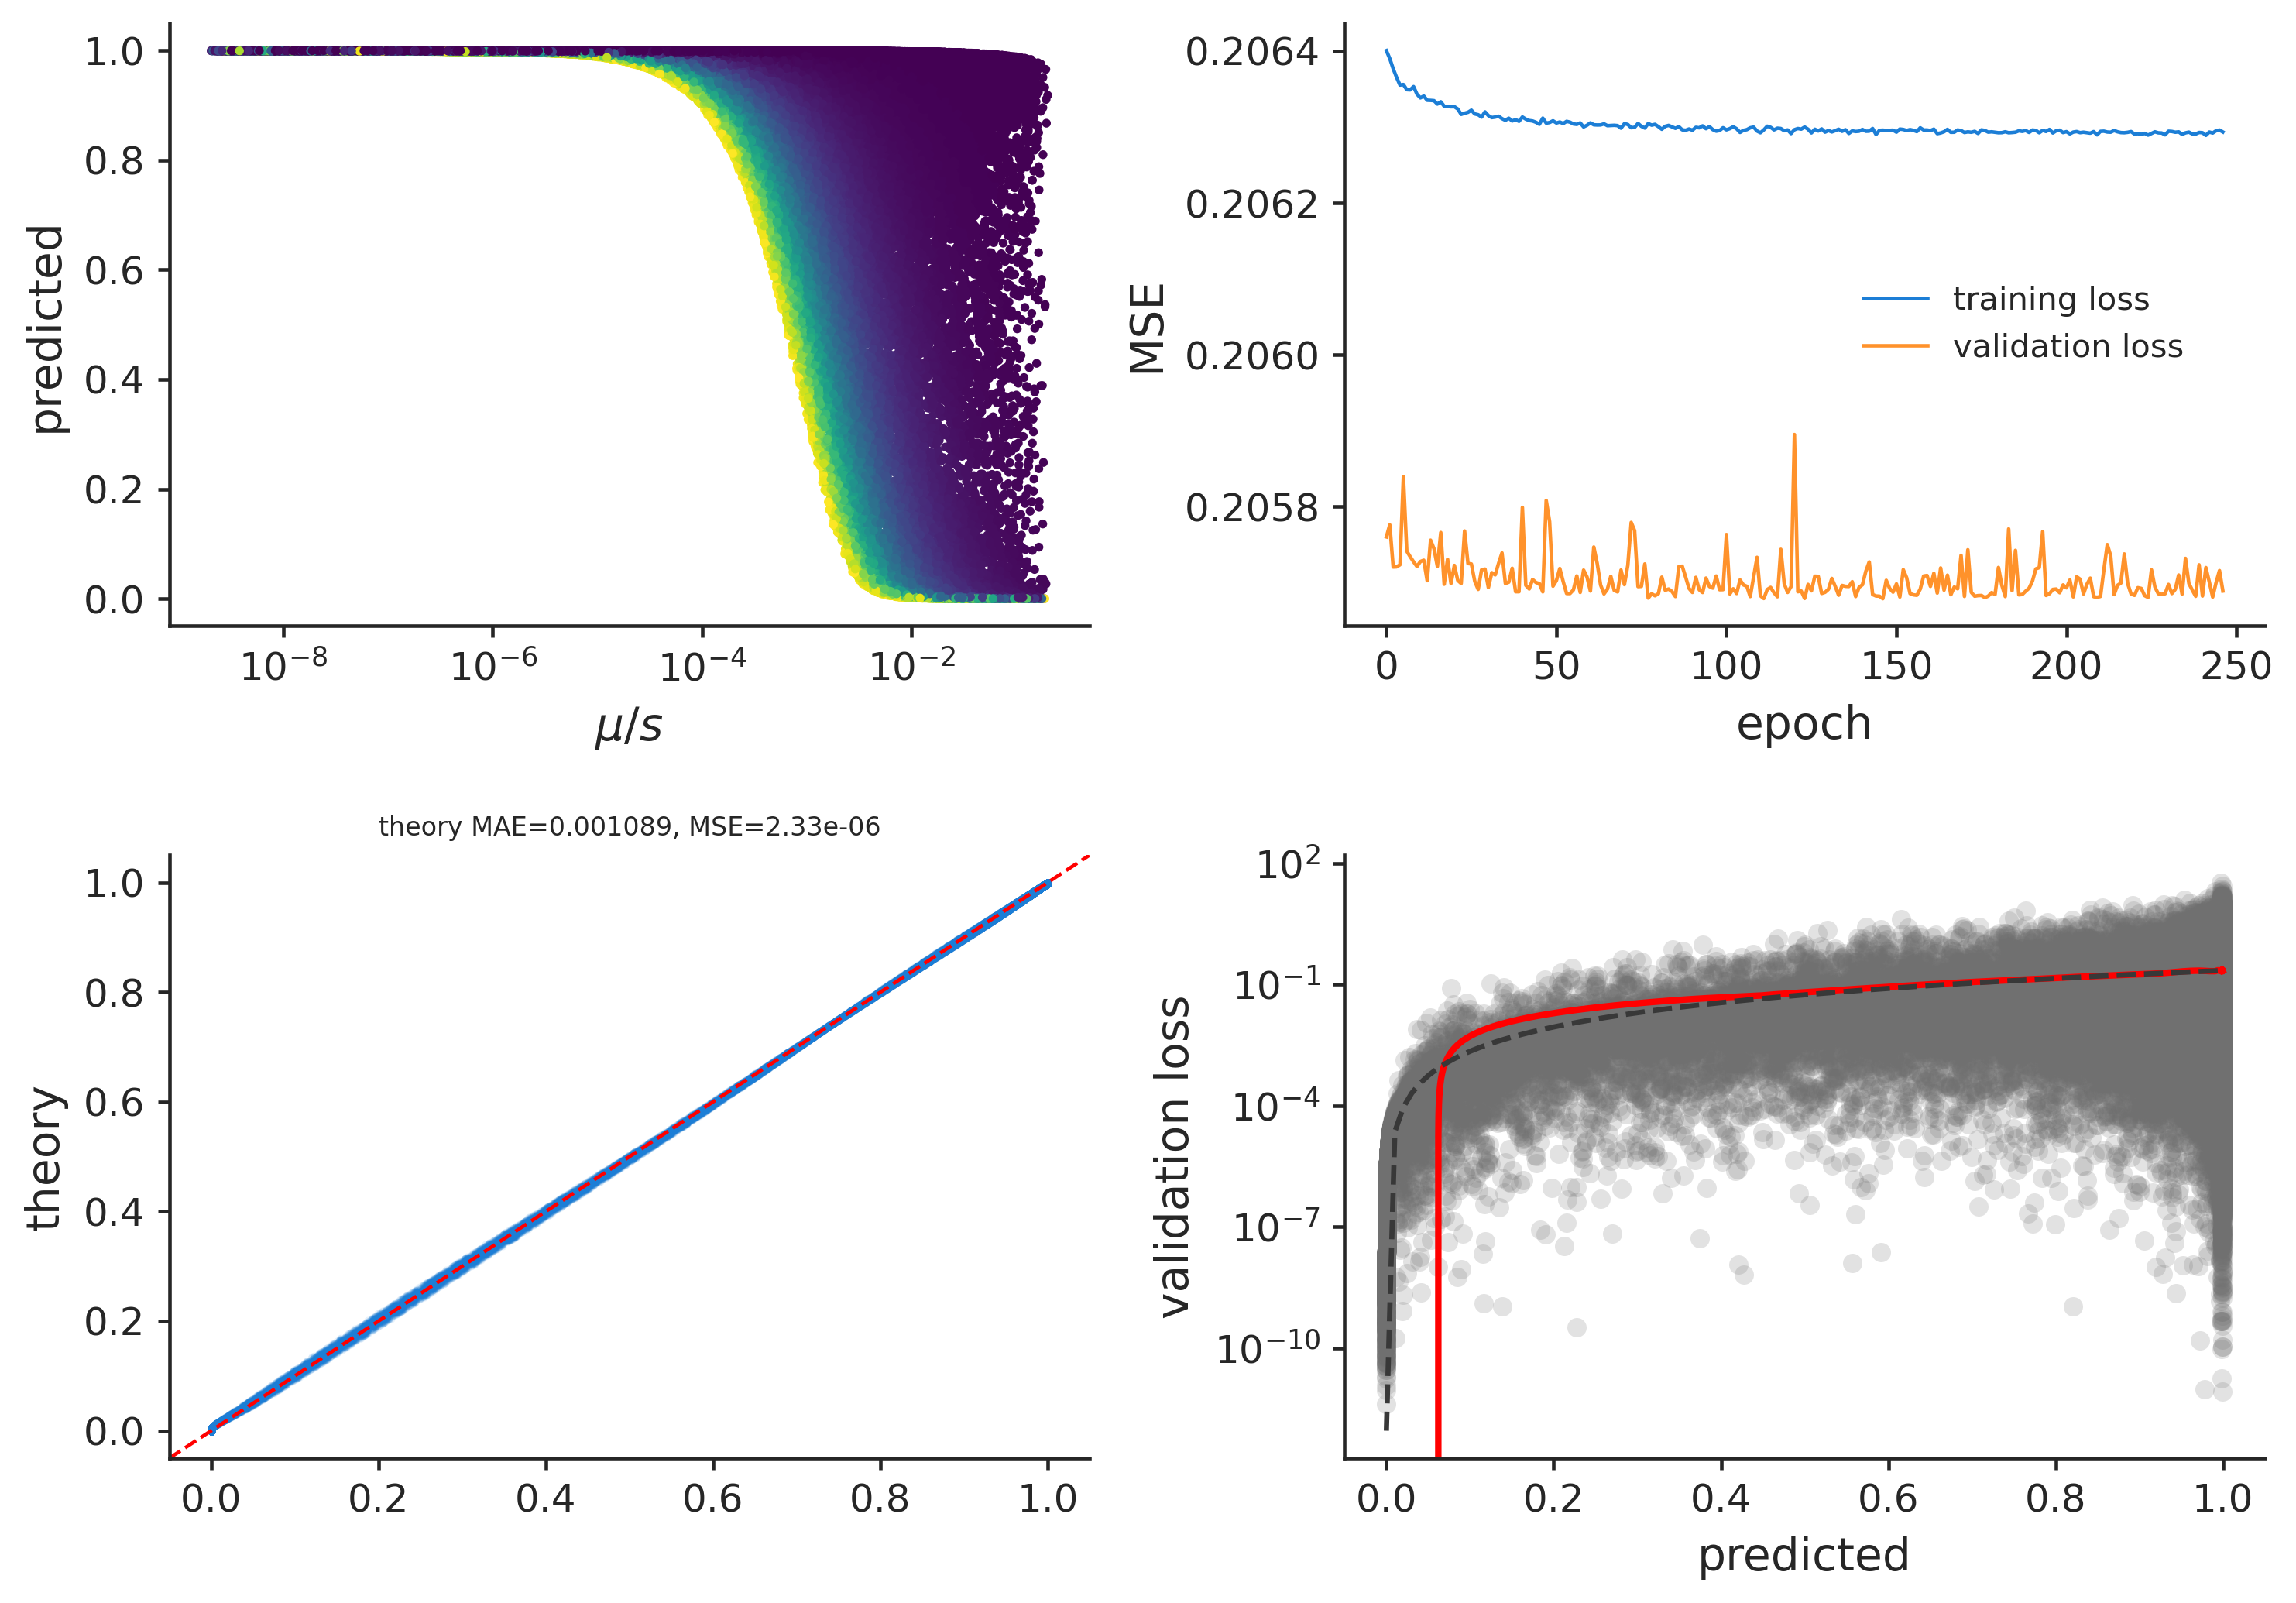

In [24]:
b_learn_diagnostic_plot(res['simple_varlogL'][ARCH][0], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10}, c='L', add_theory=False)

### Variable $\mu$, $t$, $L$, and $r_\mathrm{BP}$ — Everything Log-scaled

In [25]:
res['simple_varlogL_varrbp'][ARCH][0].func

LearnedFunction with 4 feature(s)
 variable feature(s):
  - rbp ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - L ∈ [-1, 3.04] (log10, <ufunc 'log10'>)
  - mu ∈ [-10, -5] (log10, <ufunc 'log10'>)
  - sh ∈ [-4.3, -1.3] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
  - N = 1000
Features normalized? True
Features split? True, test size: 20.0% (n=200,000)
Total size: 1,000,000

(<Figure size 2700x750 with 3 Axes>,
 <AxesSubplot:title={'center':'n128=0, n64=0, n32=0, n8=0, n4=4'}>)

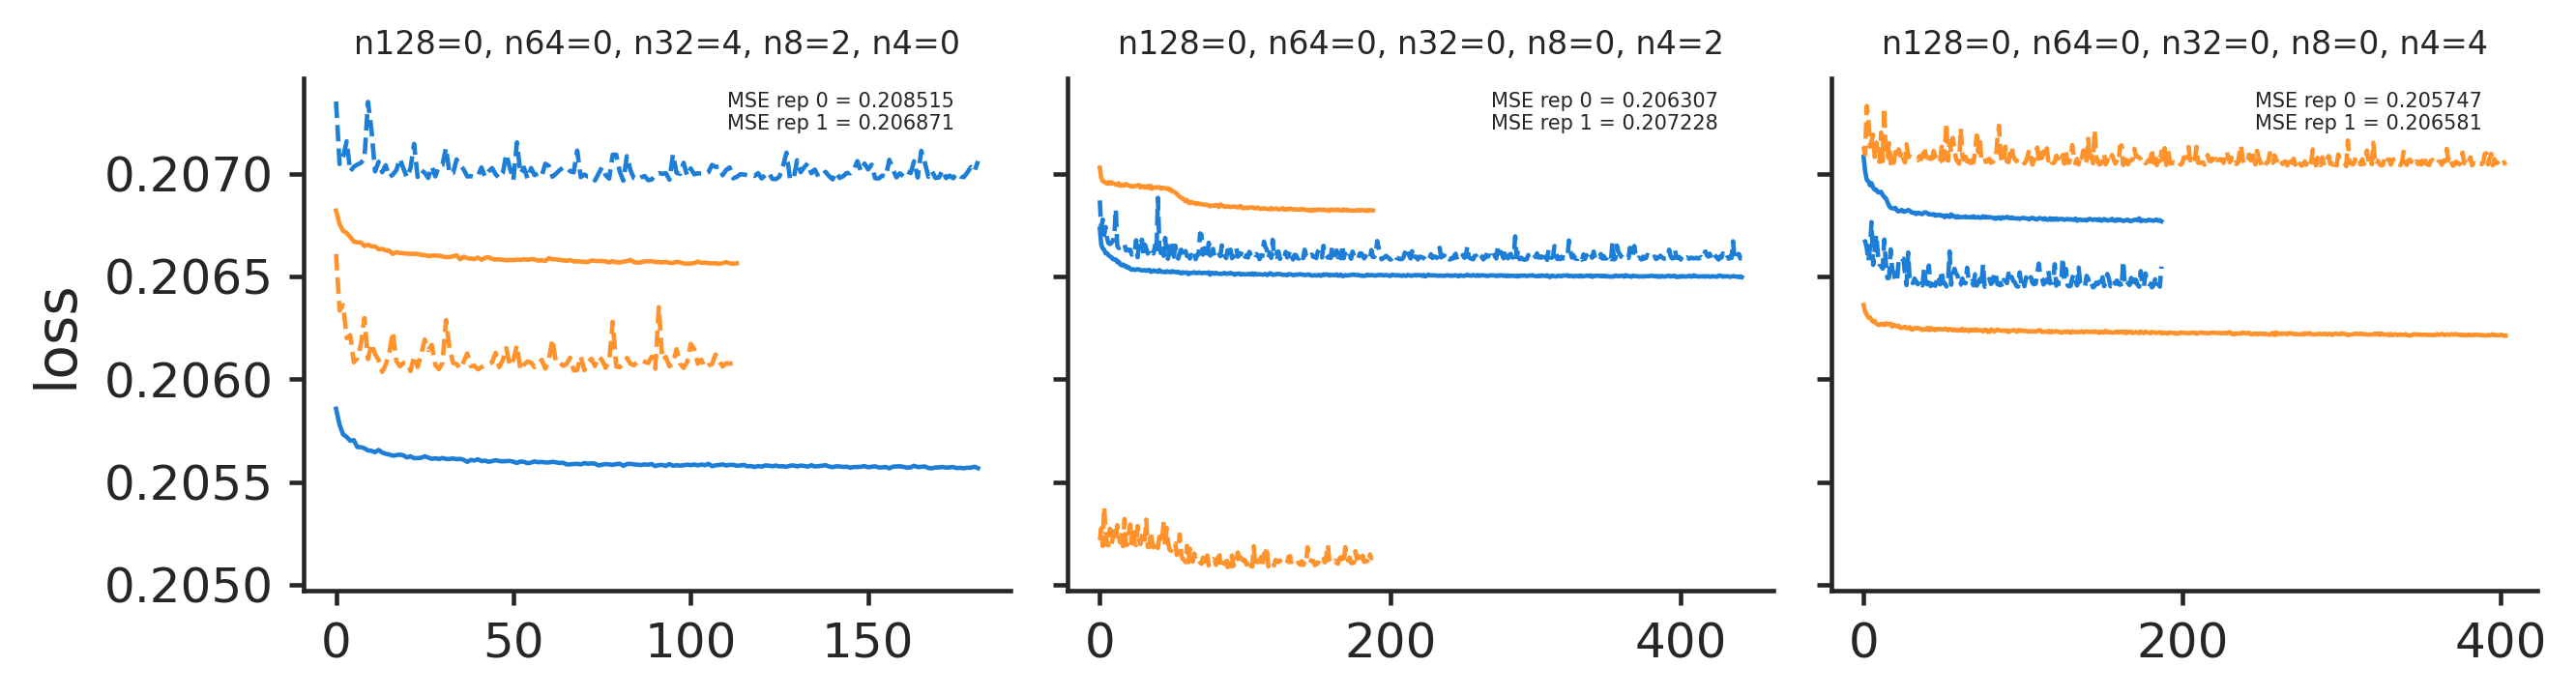

In [26]:
arch_loss_plot(res['simple_varlogL_varrbp'])

In [101]:
res['simple_varlogL_varrbp'][ARCH][1].func.features

{'rbp': 0, 'L': 1, 'mu': 2, 'sh': 3}

(<Figure size 3000x2100 with 4 Axes>,
 ((<AxesSubplot:xlabel='$\\mu/s$', ylabel='predicted'>,
   <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:title={'center':'\ntheory MAE=0.001546, MSE=7.66e-06'}, ylabel='theory'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

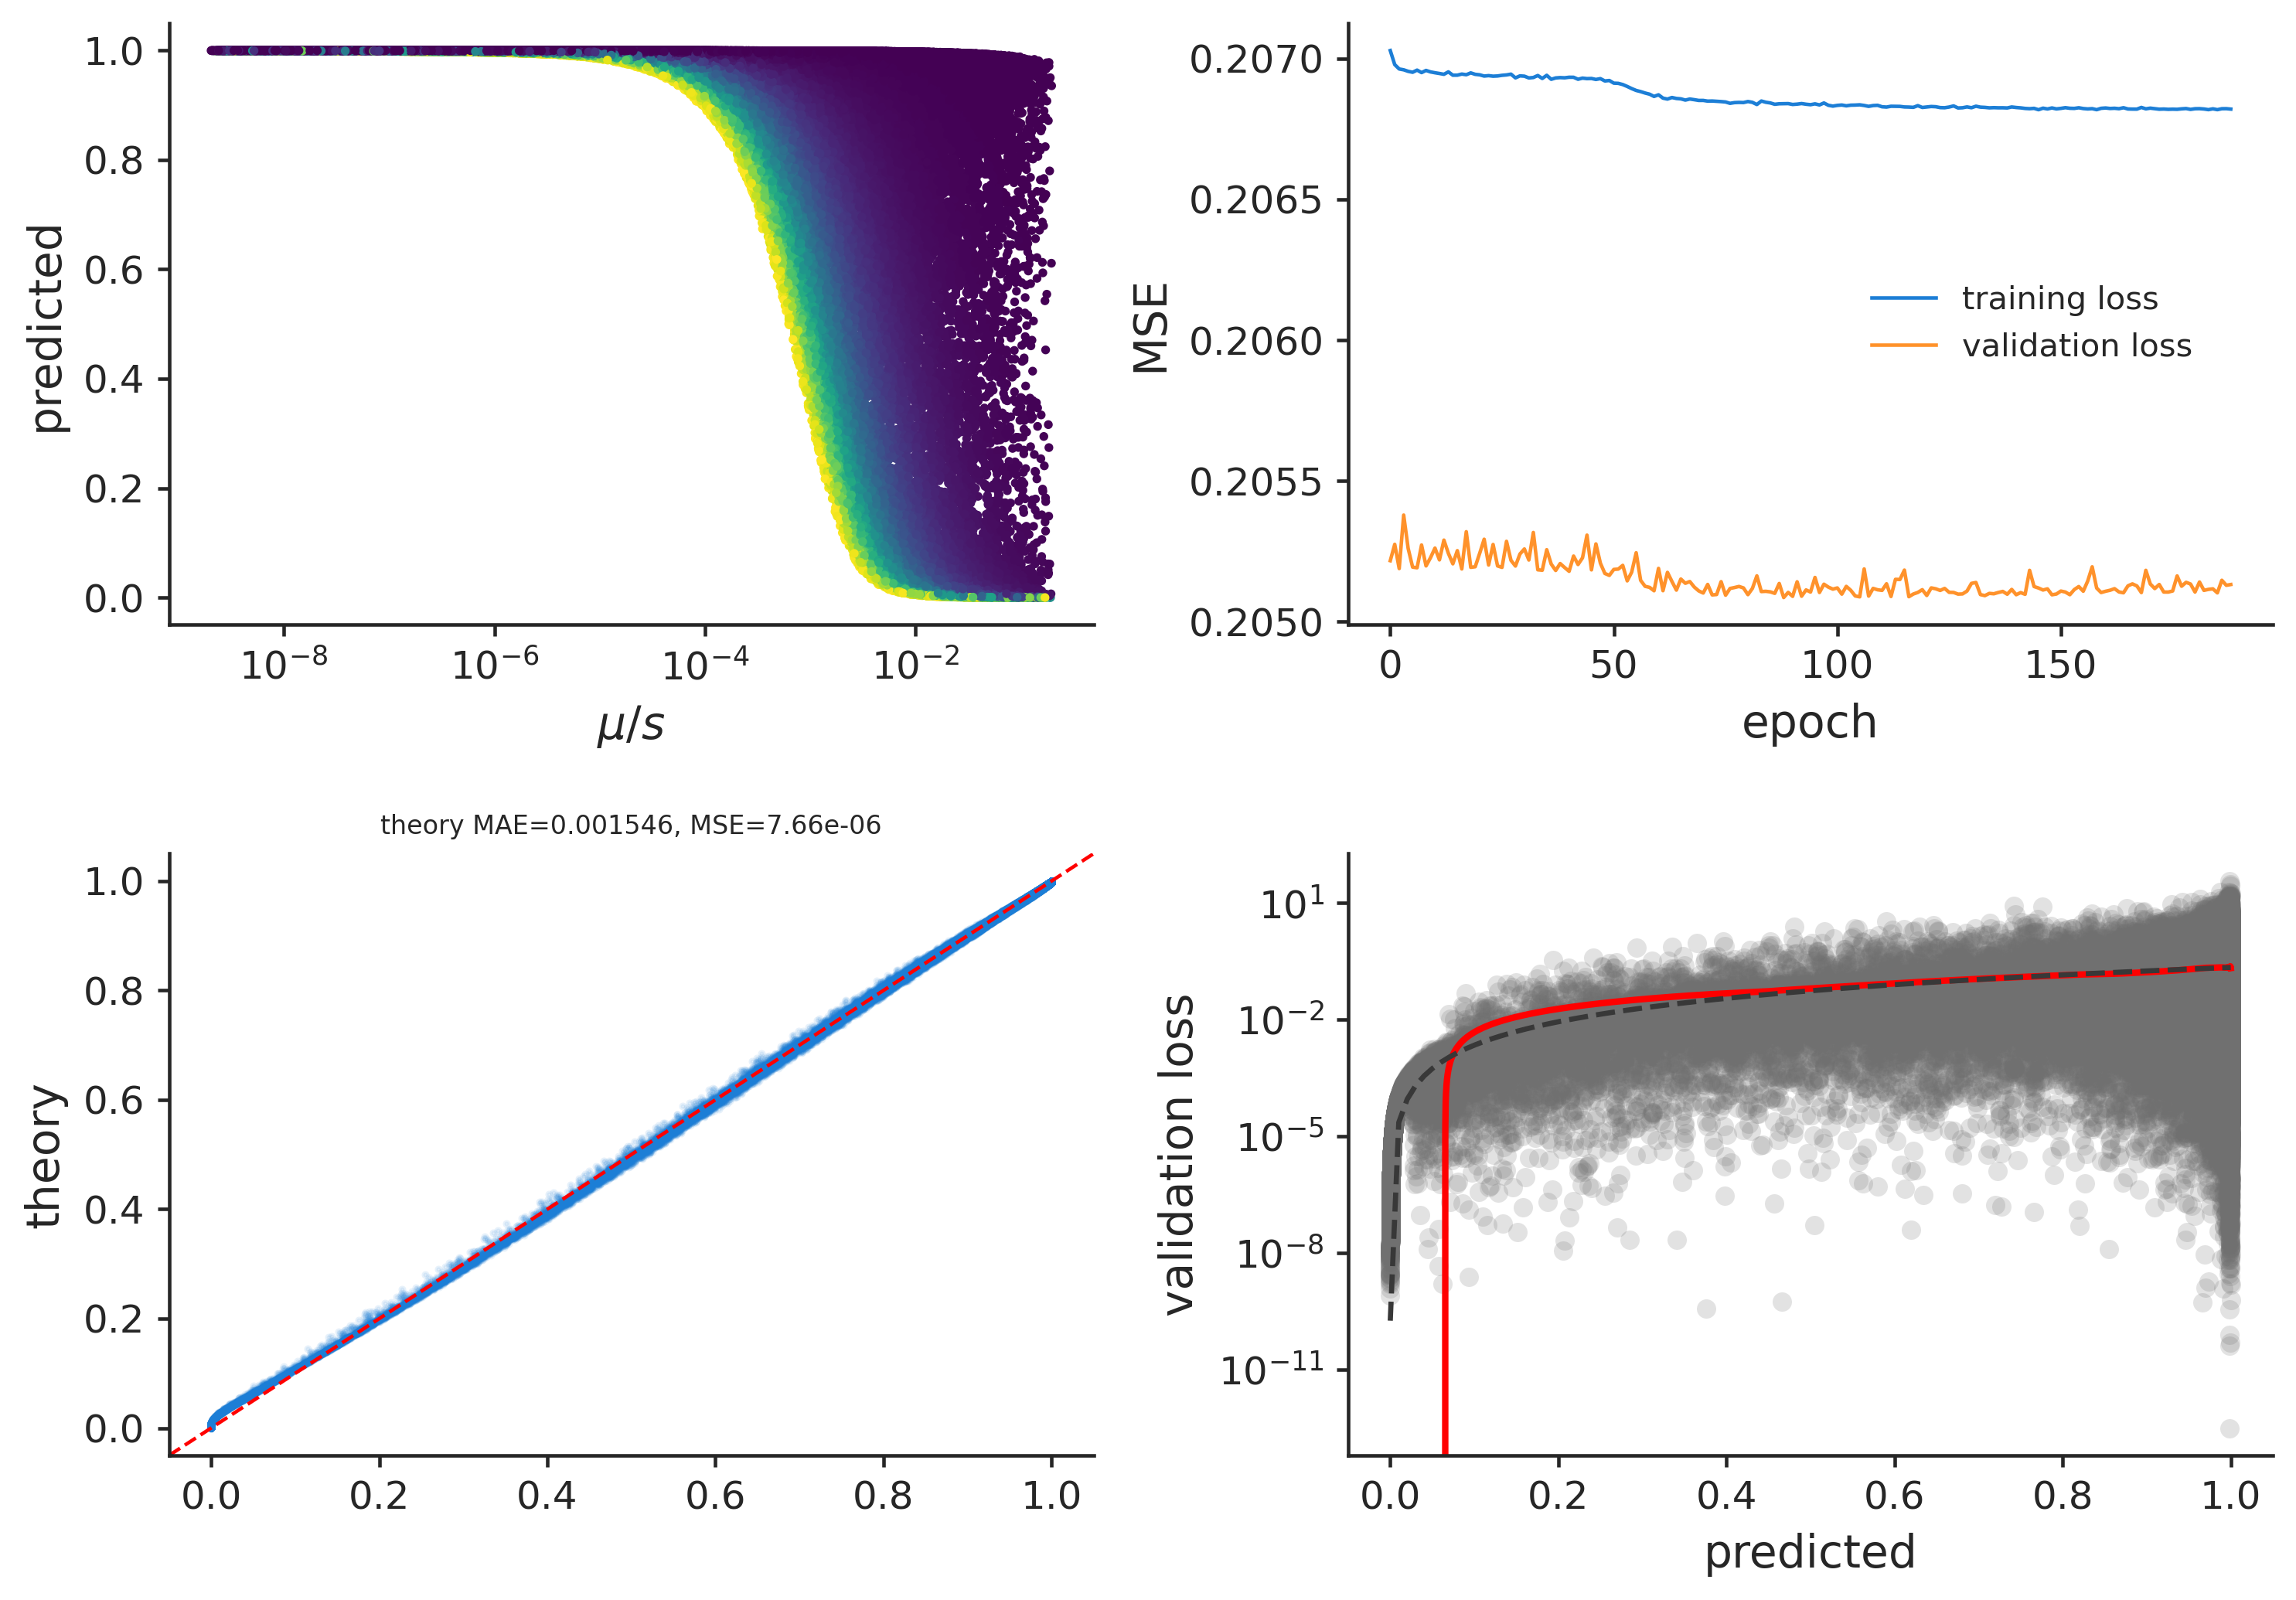

In [27]:
b_learn_diagnostic_plot(res['simple_varlogL_varrbp'][ARCH][1], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

Note there is a lot of variability here between model fits!

## Varying Number of Samples

In [28]:
models = [f for f in os.listdir(FIT_DIR) if f.startswith('varying_nsamples')]
res_nsamp = {m: load_learnedfuncs_in_dir(os.path.join(FIT_DIR, m)) for m in models}

res_nsamp.keys()

dict_keys(['varying_nsamples_500000_2', 'varying_nsamples_100000_2', 'varying_nsamples_1000000_1', 'varying_nsamples_1000_1', 'varying_nsamples_2000000_5', 'varying_nsamples_2000000_10', 'varying_nsamples_5000_2', 'varying_nsamples_50000_5', 'varying_nsamples_50000_10', 'varying_nsamples_50000_1', 'varying_nsamples_2000000_2', 'varying_nsamples_500000_10', 'varying_nsamples_5000_10', 'varying_nsamples_1000_10', 'varying_nsamples_5000_1', 'varying_nsamples_2000000_1', 'varying_nsamples_100000_10', 'varying_nsamples_500000_5', 'varying_nsamples_10000_10', 'varying_nsamples_1000000_10', 'varying_nsamples_1000_2', 'varying_nsamples_10000_5', 'varying_nsamples_100000_5', 'varying_nsamples_10000_1', 'varying_nsamples_500000_1', 'varying_nsamples_1000_5', 'varying_nsamples_10000_2', 'varying_nsamples_1000000_2', 'varying_nsamples_1000000_5'])

In [29]:
nsamps, nreps, theory_maes, theory_mses = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
predict_mses, predict_maes = defaultdict(list), defaultdict(list)

def get_nsamps_nrps(model):
    match = re.match(r'varying_nsamples_(?P<nsamps>\d+)_(?P<nreps>\d+)', model)
    assert match is not None
    return tuple(map(int, match.groups()))

for name, archs in res_nsamp.items():
    nsamp, nrep = get_nsamps_nrps(name)
    for arch in archs.keys():
        for func in archs[arch]:
            nsamps[arch].append(nsamp)
            nreps[arch].append(nrep)
            theory_maes[arch].append(func.theory_loss(loss='mae'))            
            theory_mses[arch].append(func.theory_loss(loss='mse'))
            predict_maes[arch].append(func.predict_loss(loss='mae'))
            predict_mses[arch].append(func.predict_loss(loss='mse'))            

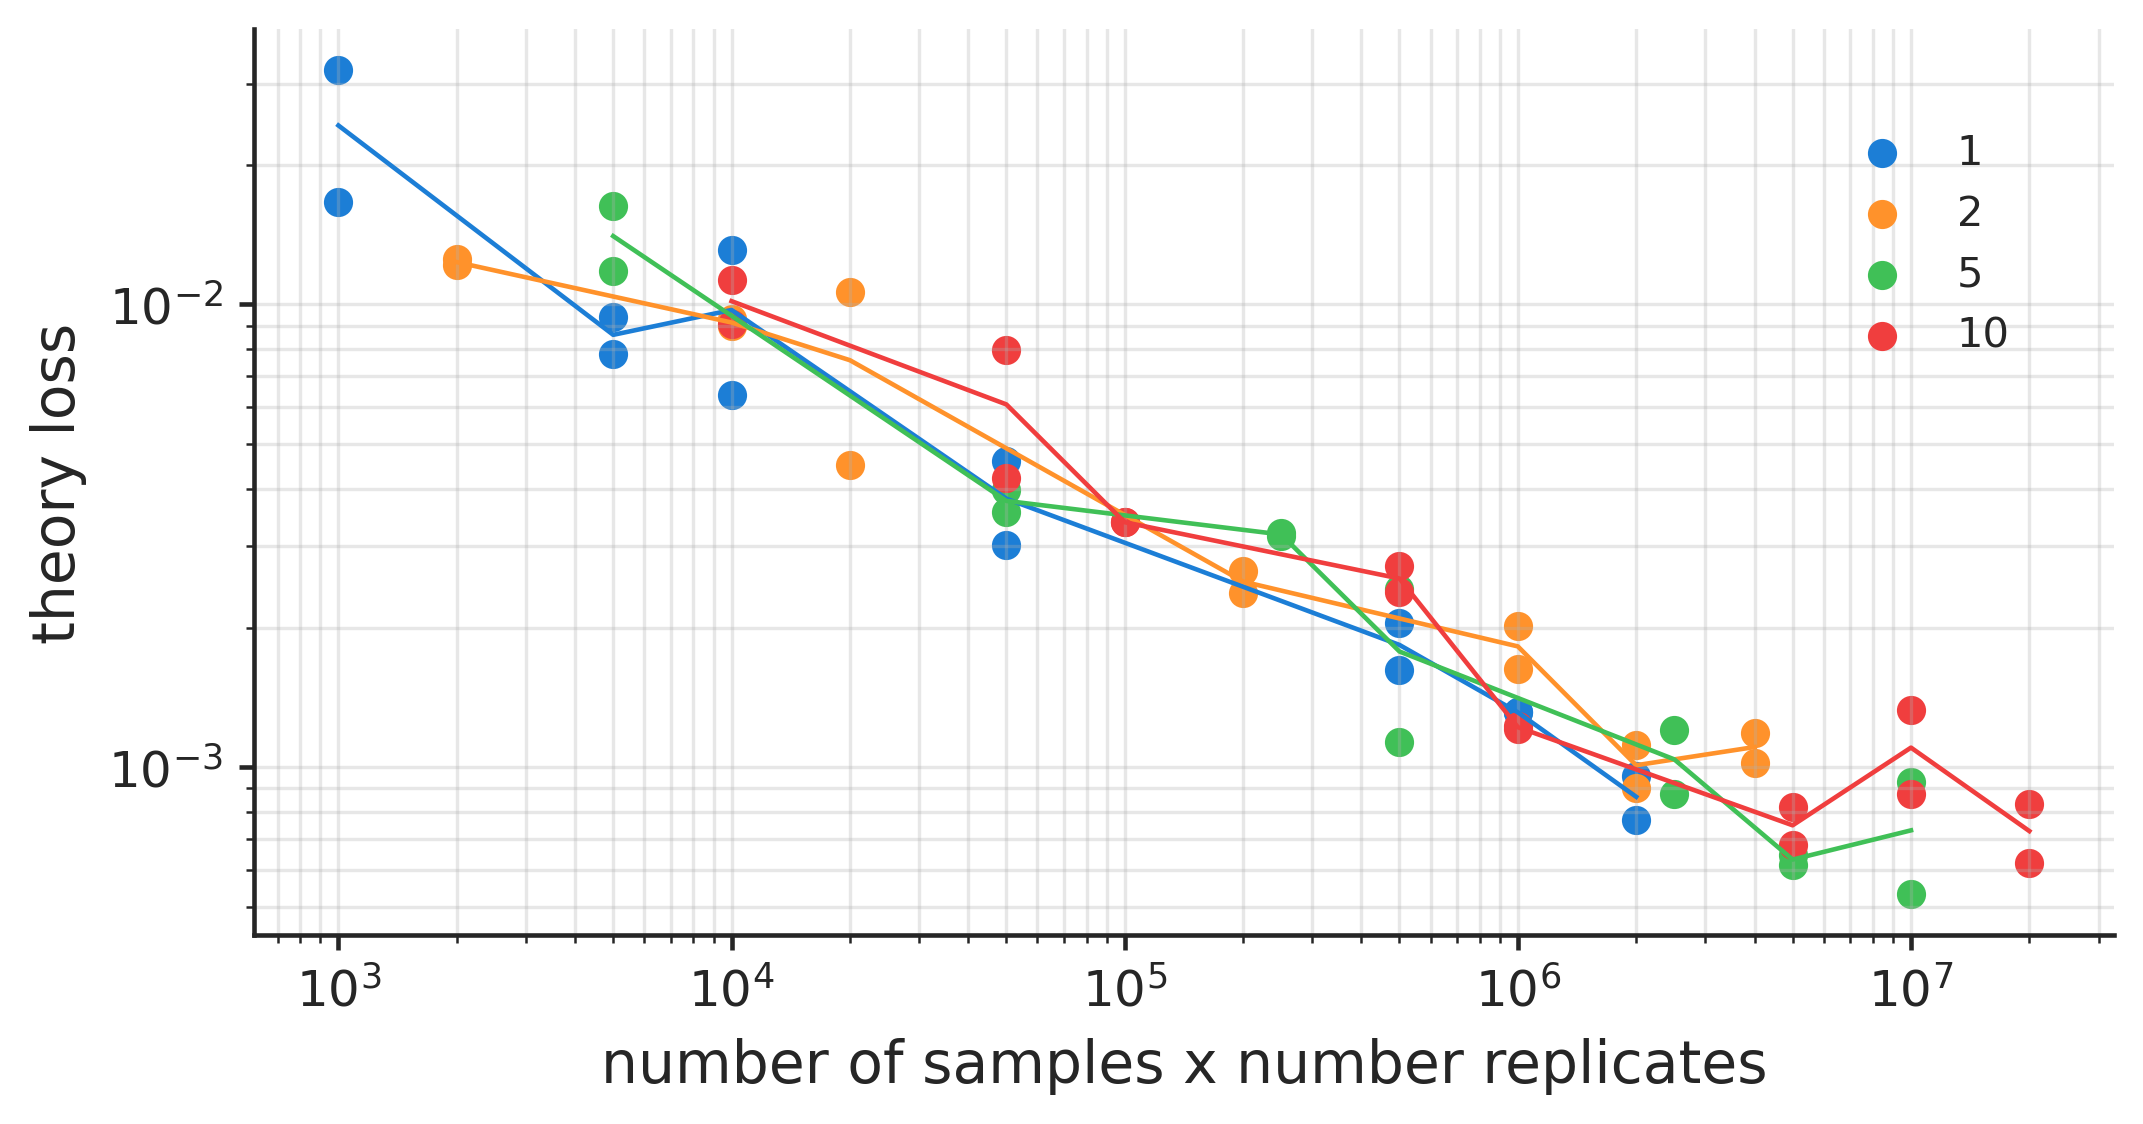

In [43]:
ARCH = (0, 0, 0, 0, 2)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()

for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values * nrep, dfg['theory_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
semilog = False
if semilog:
    ax.semilogx()
else:
    ax.loglog()
ax.legend()
ax.set_ylabel("theory loss")
ax.set_xlabel("number of samples x number replicates")
ax.grid(which='both')

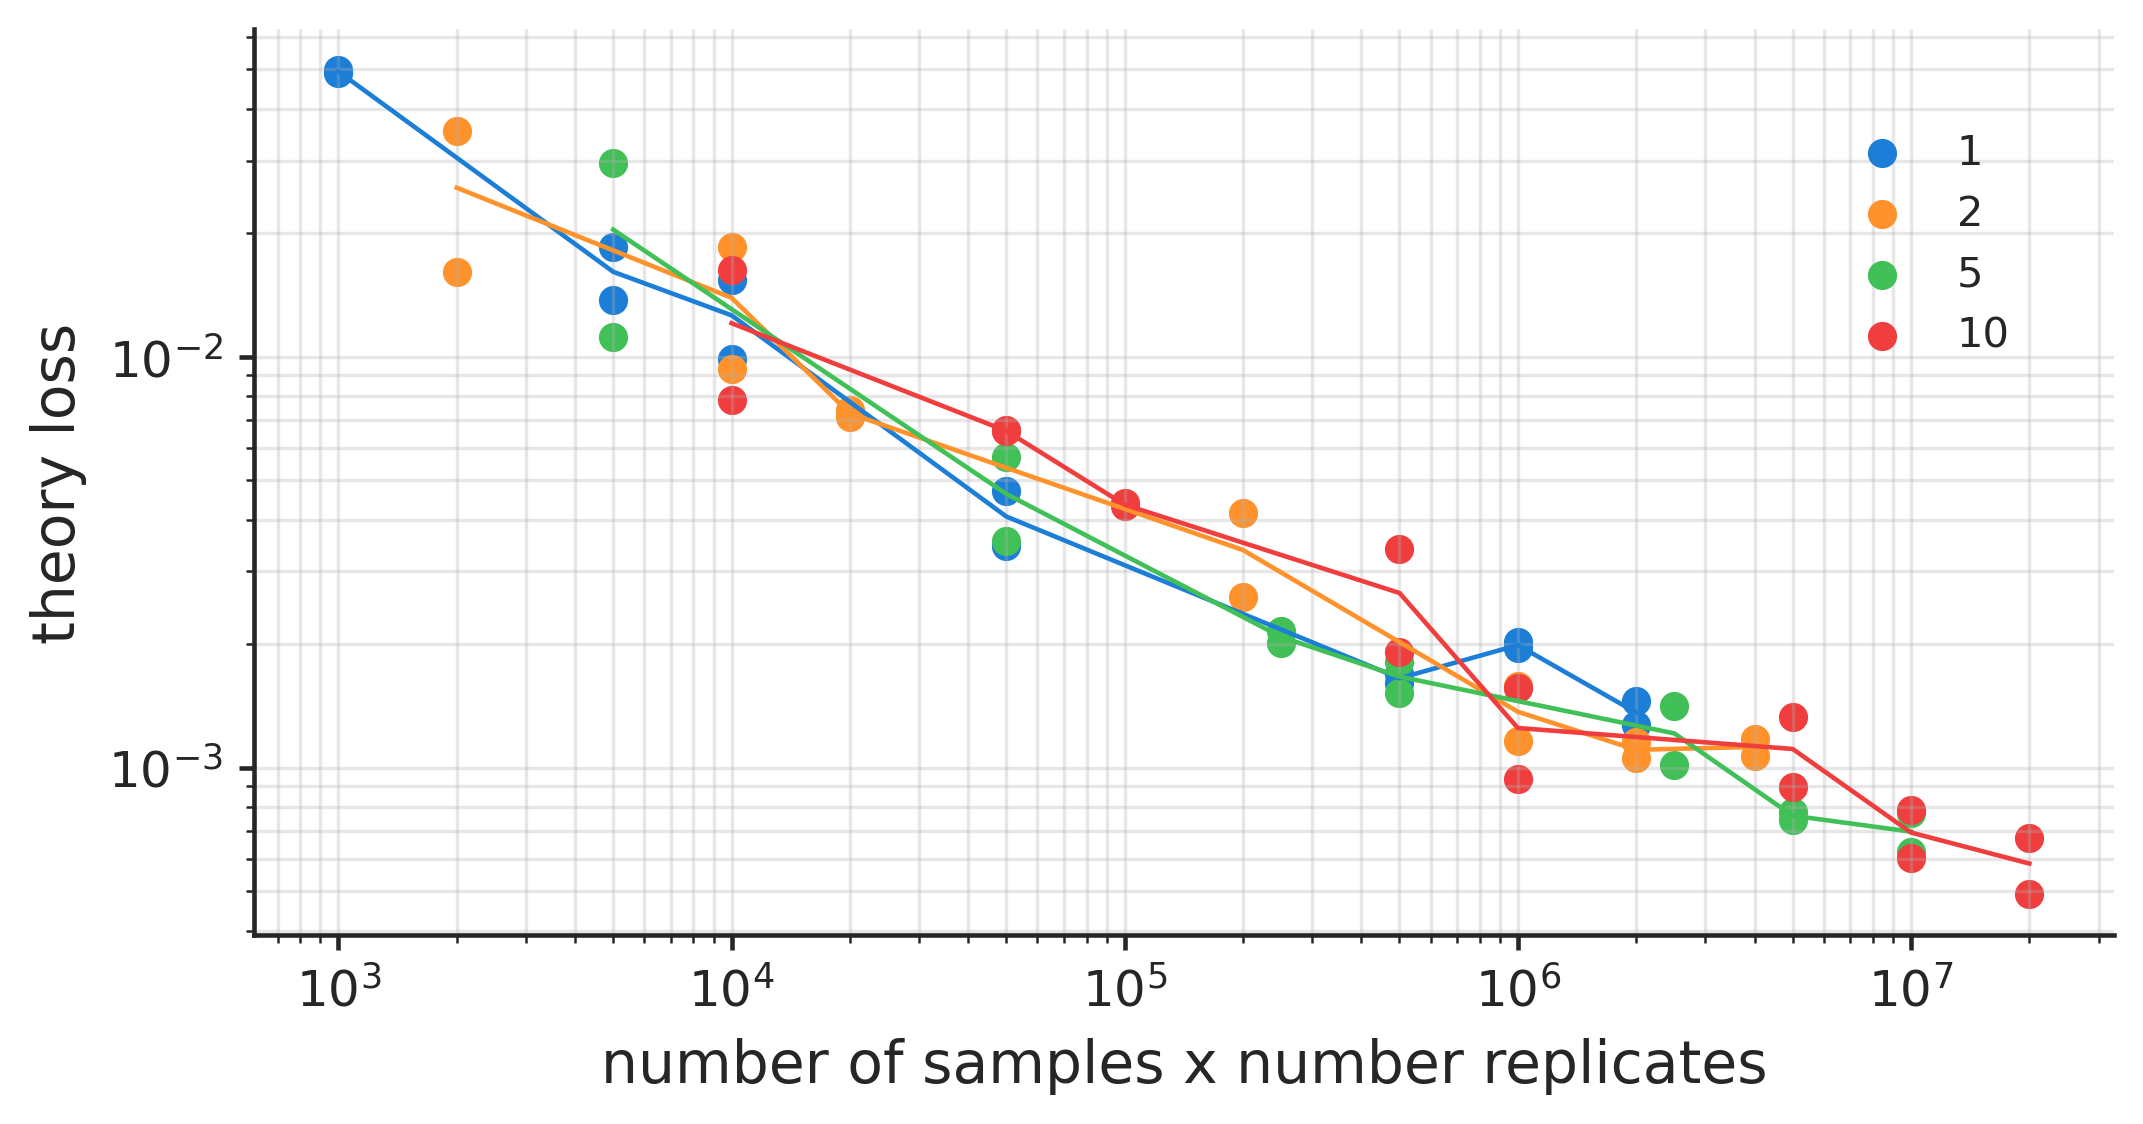

In [44]:
ARCH = (0, 0, 0, 0, 4)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()

for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values * nrep, dfg['theory_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
semilog = False
if semilog:
    ax.semilogx()
else:
    ax.loglog()
ax.legend()
ax.set_ylabel("theory loss")
ax.set_xlabel("number of samples x number replicates")
ax.grid(which='both')

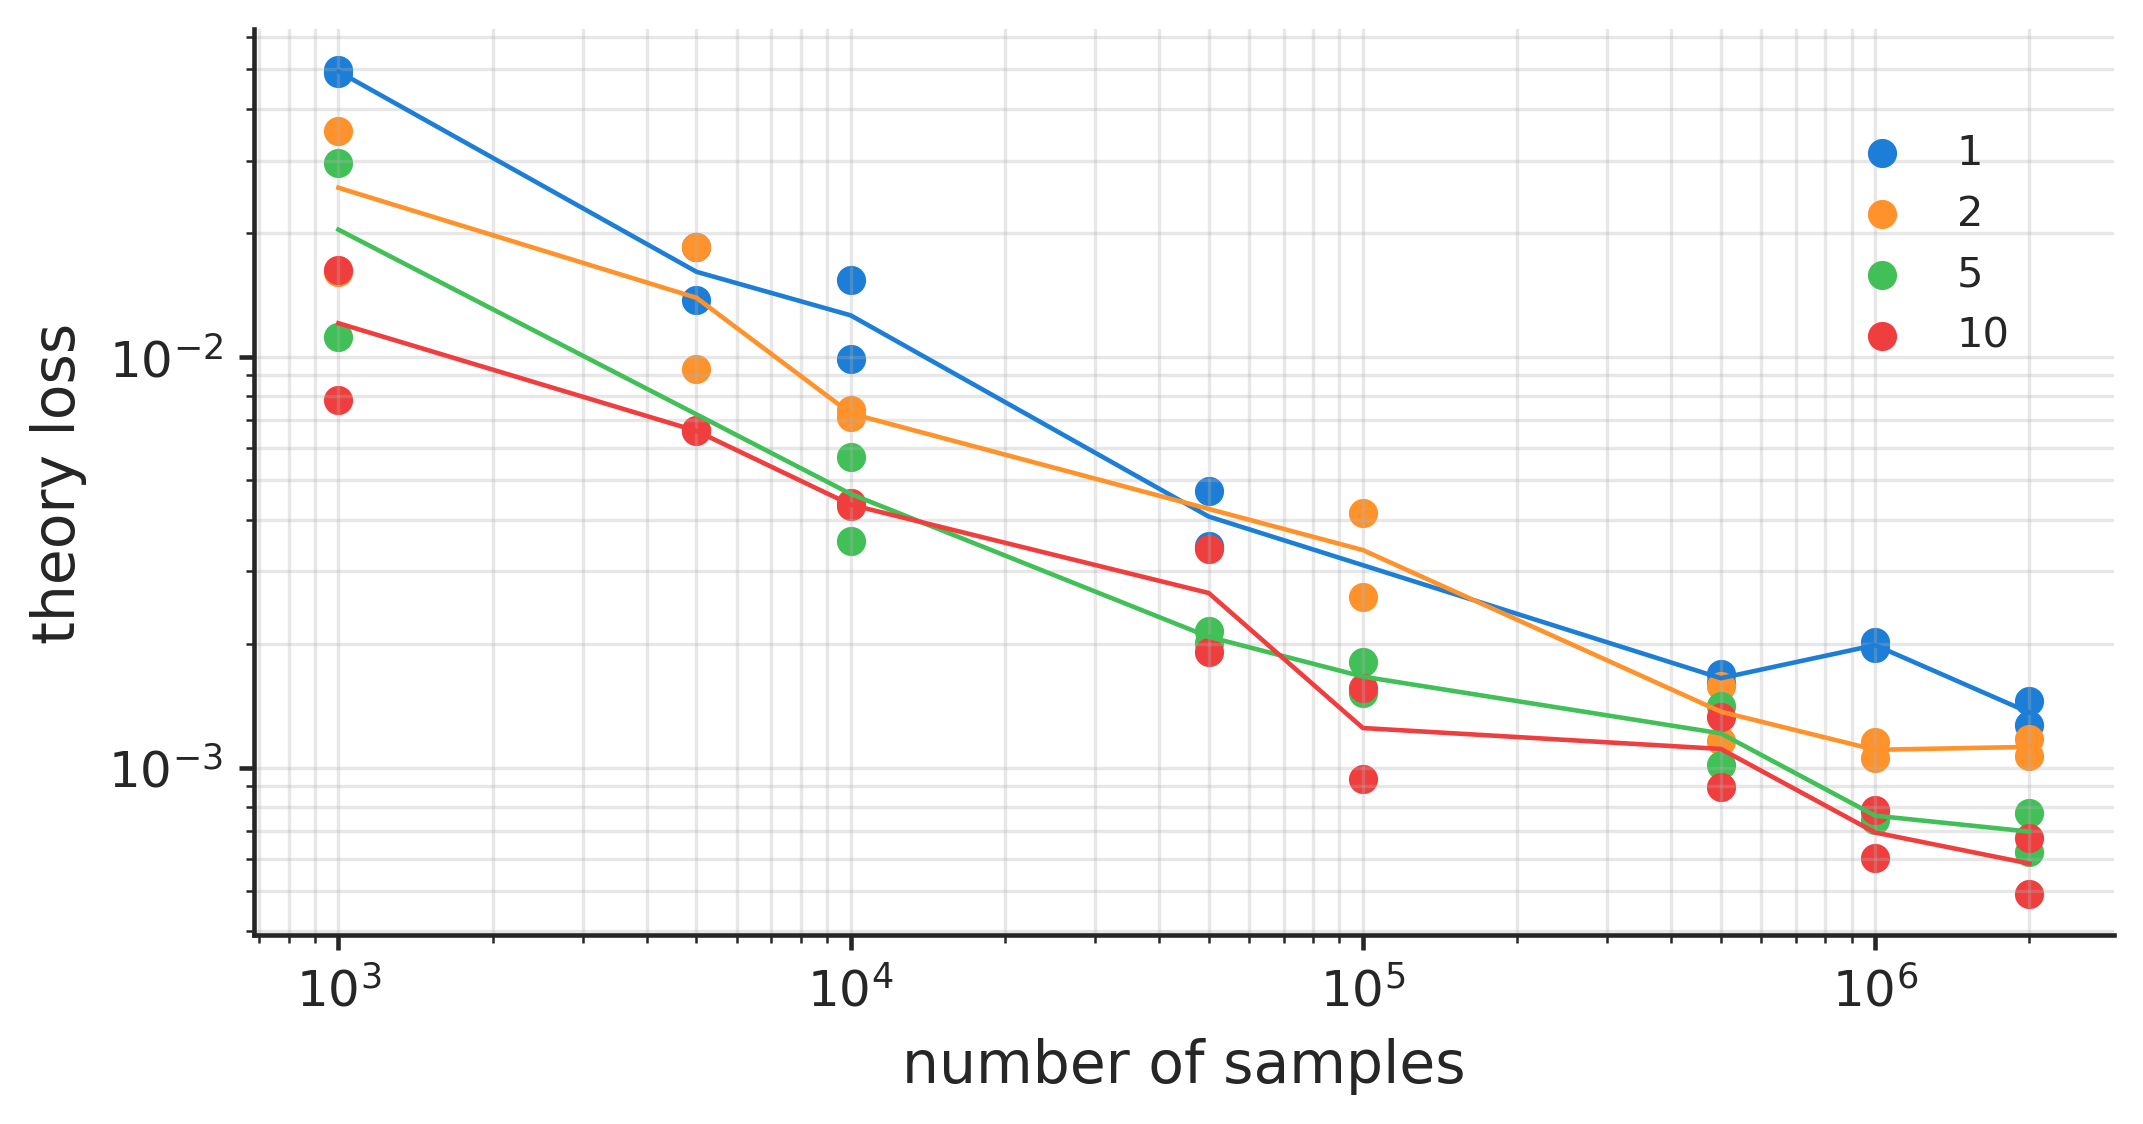

In [45]:
ARCH = (0, 0, 0, 0, 4)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()
for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values, dfg['theory_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
semilog = False
if semilog:
    ax.semilogx()
else:
    ax.loglog()
ax.legend()
ax.set_ylabel("theory loss")
ax.set_xlabel("number of samples")
ax.grid(which='both')

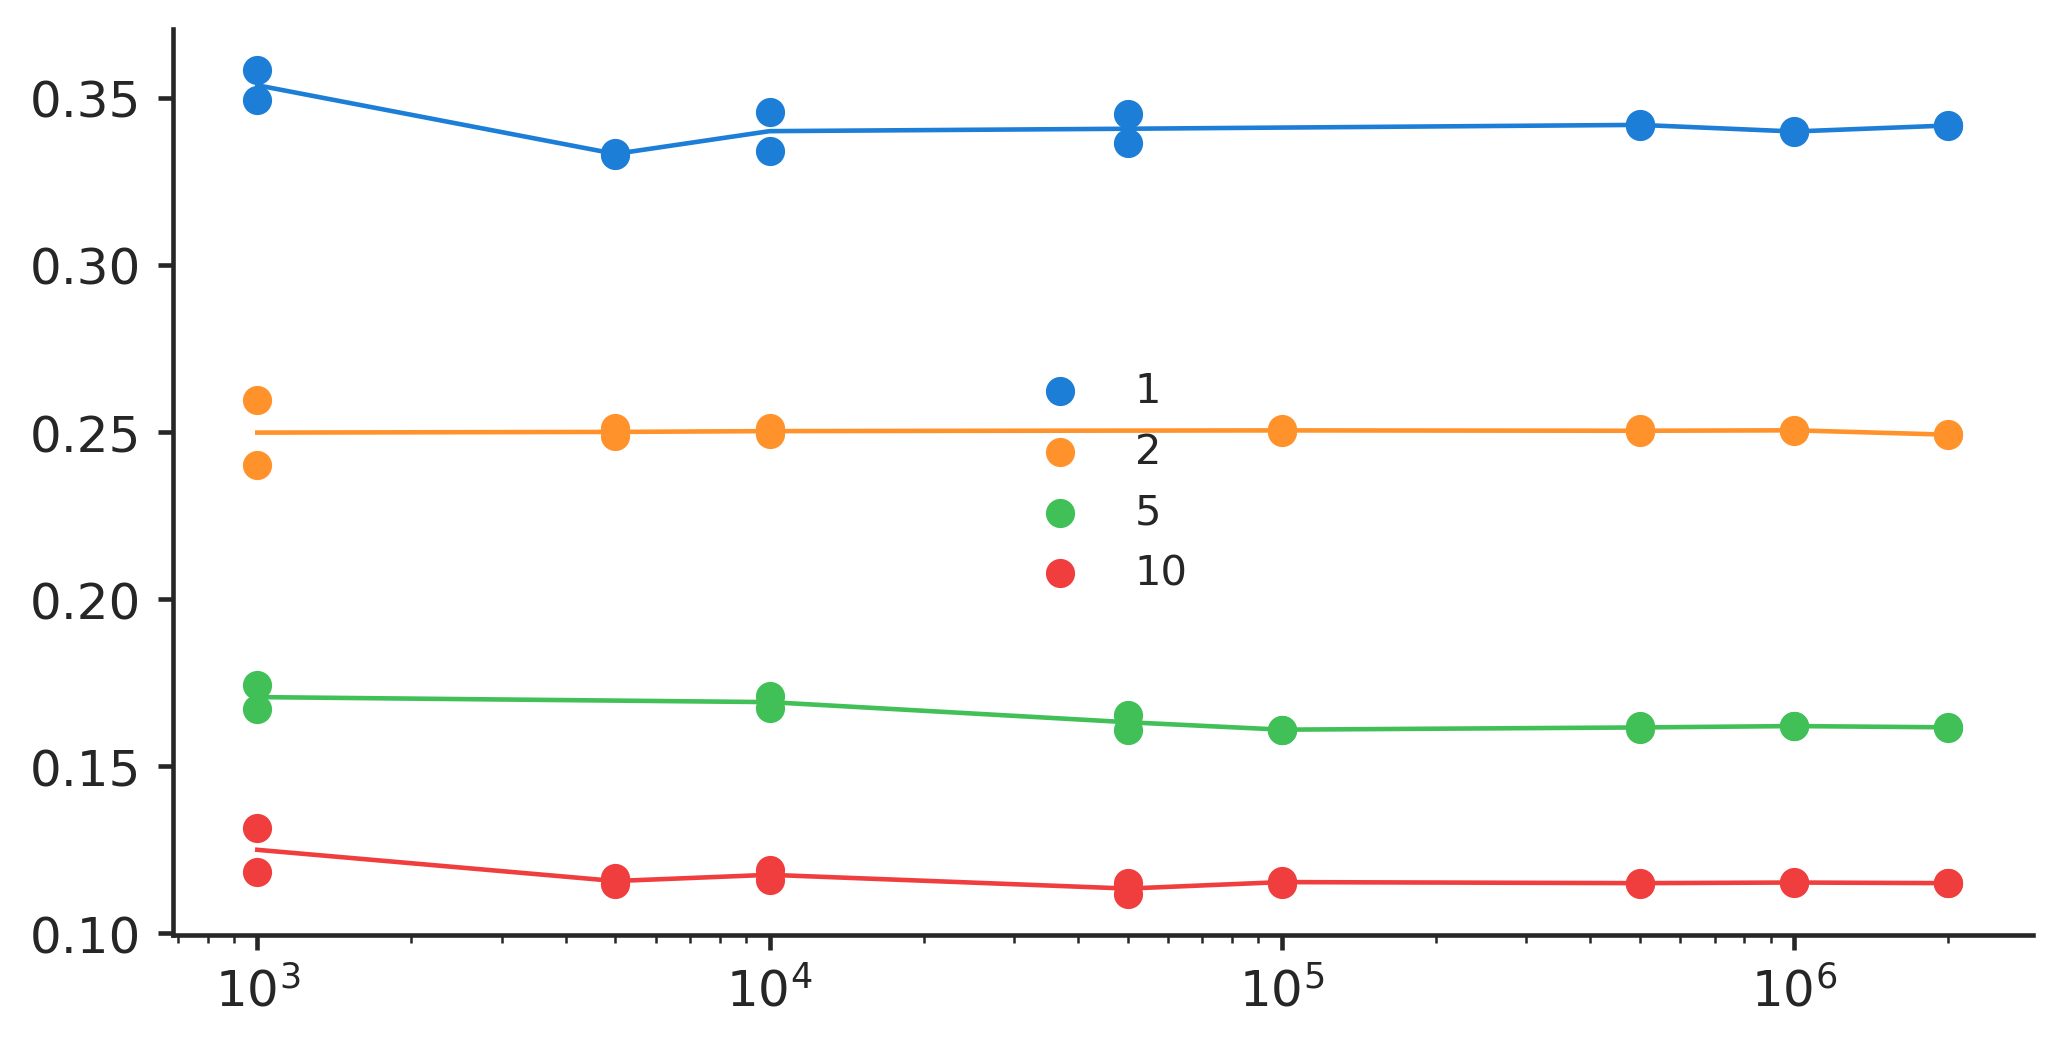

In [46]:
ARCH = (0, 0, 4, 2, 0)
df = pd.DataFrame(dict(nsamps=nsamps[ARCH], nreps=nreps[ARCH], theory_mae=theory_maes[ARCH], predict_mae=predict_maes[ARCH]))

fig, ax = plt.subplots()

for nrep, dfg in df.groupby('nreps'):
    x, y = dfg['nsamps'].values.astype(int), dfg['predict_mae'].values
    idx = np.argsort(x)
    ax.scatter(x[idx], y[idx], label=nrep)
    means = defaultdict(list)
    for xx, yy in zip(x, y):
        means[xx].append(yy)
    agg_x = np.array(list(means.keys()))
    agg_y = np.array([np.mean(v) for v in means.values()])
    idx = np.argsort(agg_x)
    ax.plot(agg_x[idx], agg_y[idx])
ax.legend(loc='upper right', ncol=2)
ax.semilogx()
ax.legend()

In [47]:
res_nsamp['varying_nsamples_1000000_10'].keys()

dict_keys([(0, 0, 0, 0, 2), (0, 0, 0, 0, 4), (0, 0, 4, 2, 0)])

In [48]:
ARCH = (0, 0, 0, 0, 4)

In [49]:
def nvary_title(nsamps, nreps):
    return f"nsamps = {ns:,}, nreps={nr:,}, total={ns*nr/1e6:,}M"

(<Figure size 2400x1200 with 2 Axes>,
 <AxesSubplot:title={'center':'nsamps = 1,000,000, nreps=2, total=2.0M\ntheory MAE=0.001153, MSE=1.8e-05'}, ylabel='theory'>)

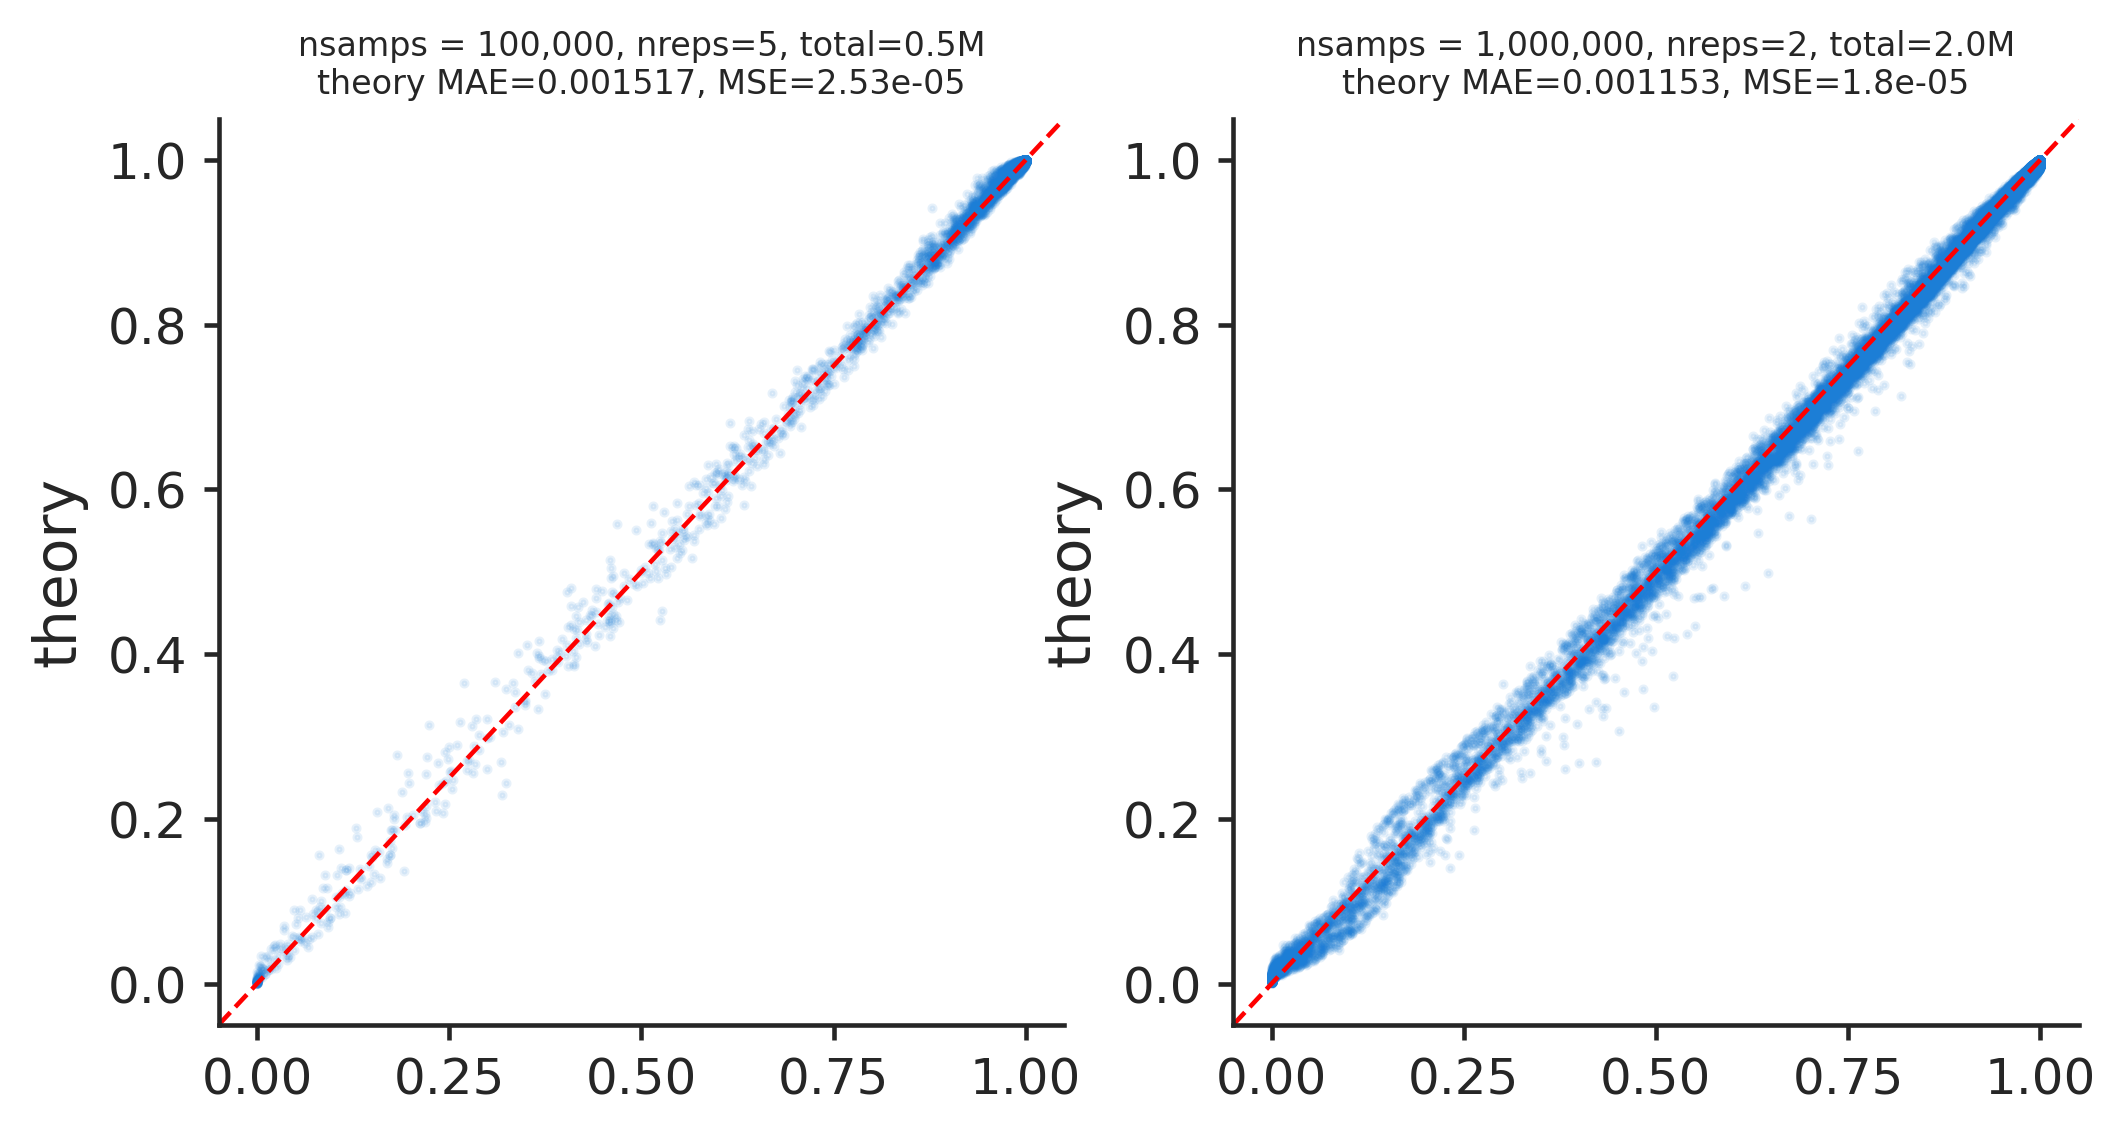

In [98]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ns, nr = 100_000, 5
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))


ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))


(<Figure size 2400x1200 with 2 Axes>,
 <AxesSubplot:title={'center':'nsamps = 1,000,000, nreps=2, total=2.0M\ntheory MAE=0.001153, MSE=1.8e-05'}, ylabel='theory'>)

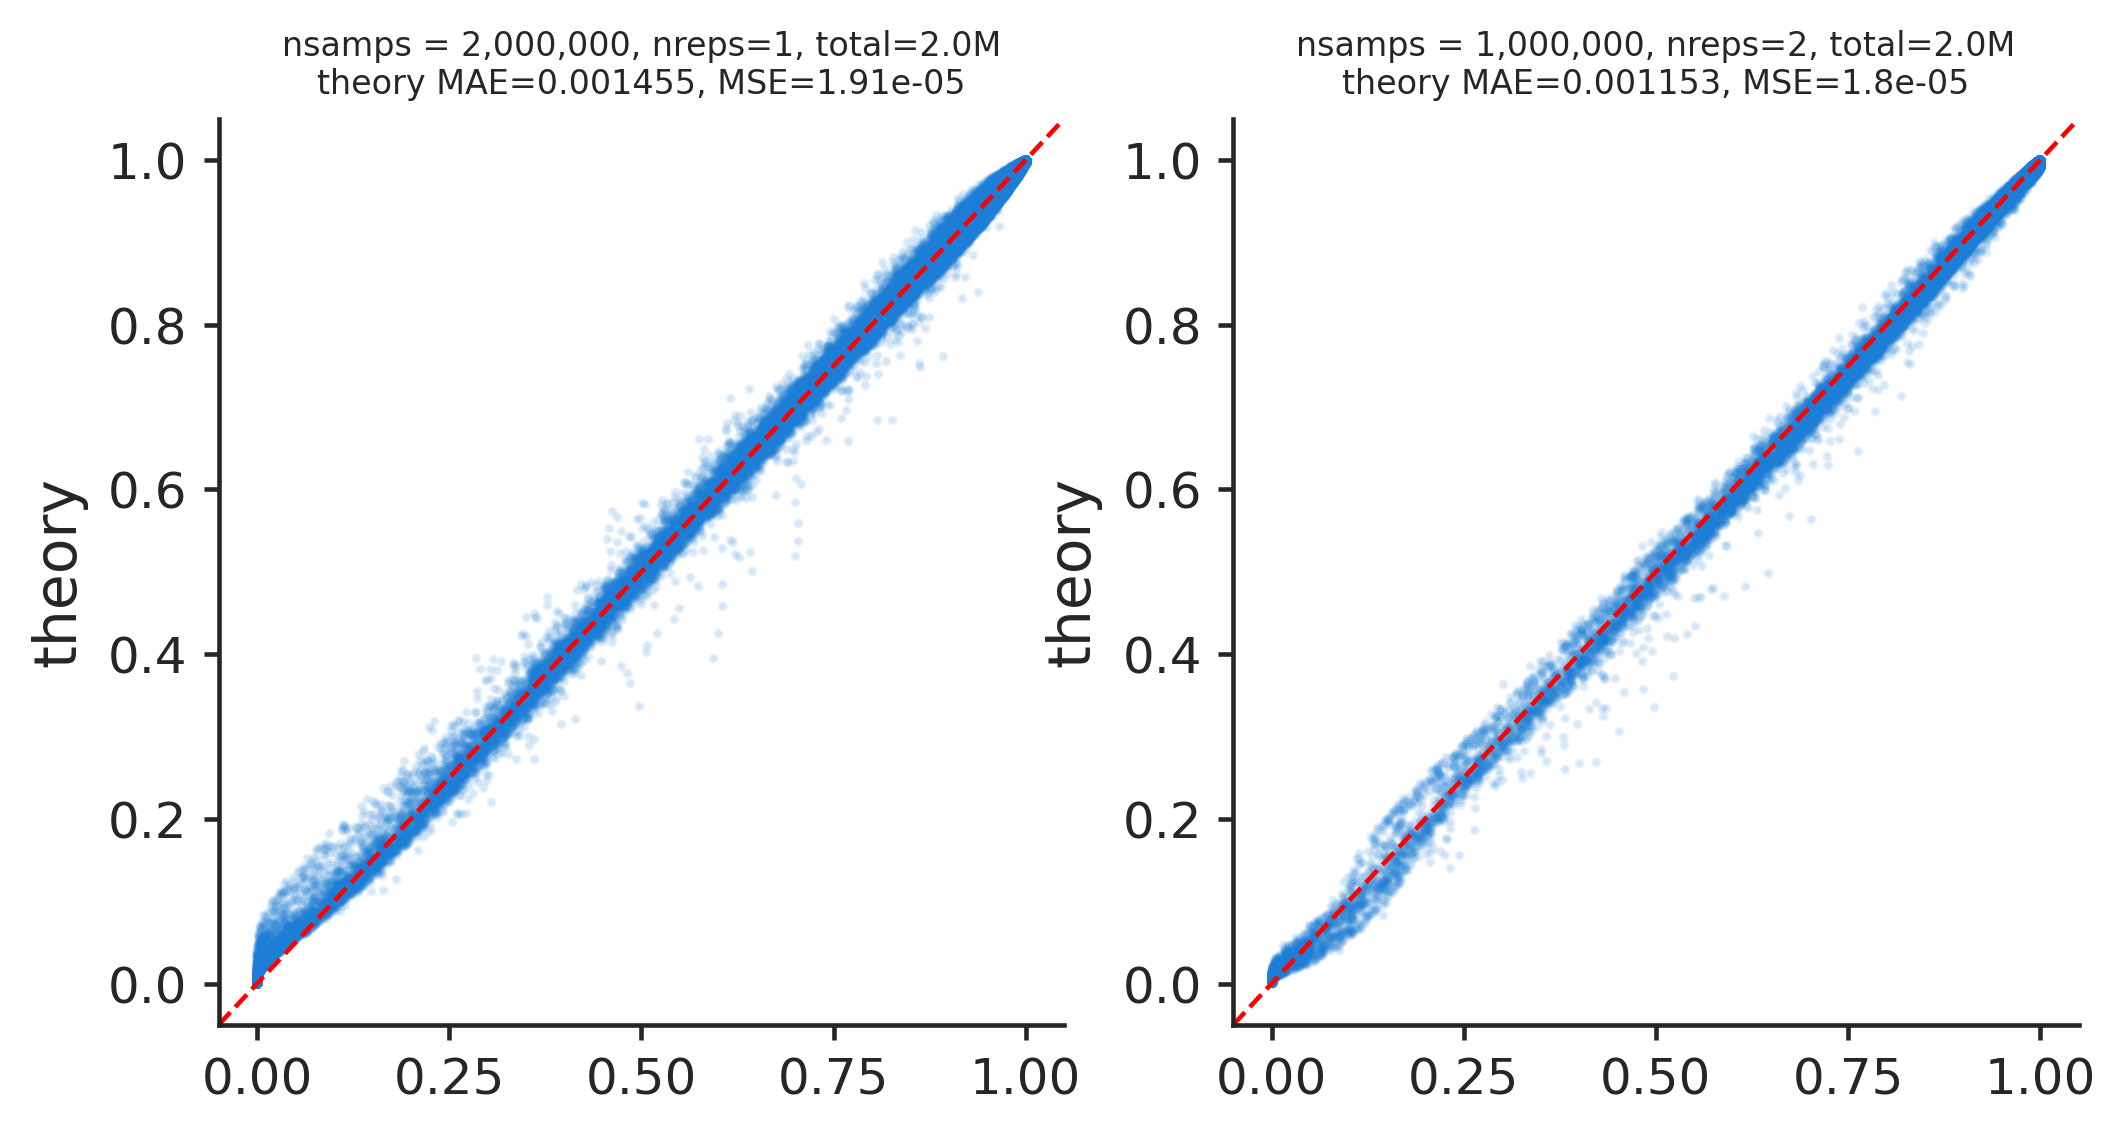

In [100]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ns, nr = 2_000_000, 1
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))


ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))


(<Figure size 2400x1200 with 2 Axes>,
 <AxesSubplot:title={'center':'nsamps = 1,000,000, nreps=2, total=2.0M\ntheory MAE=0.001153, MSE=1.8e-05'}, ylabel='theory'>)

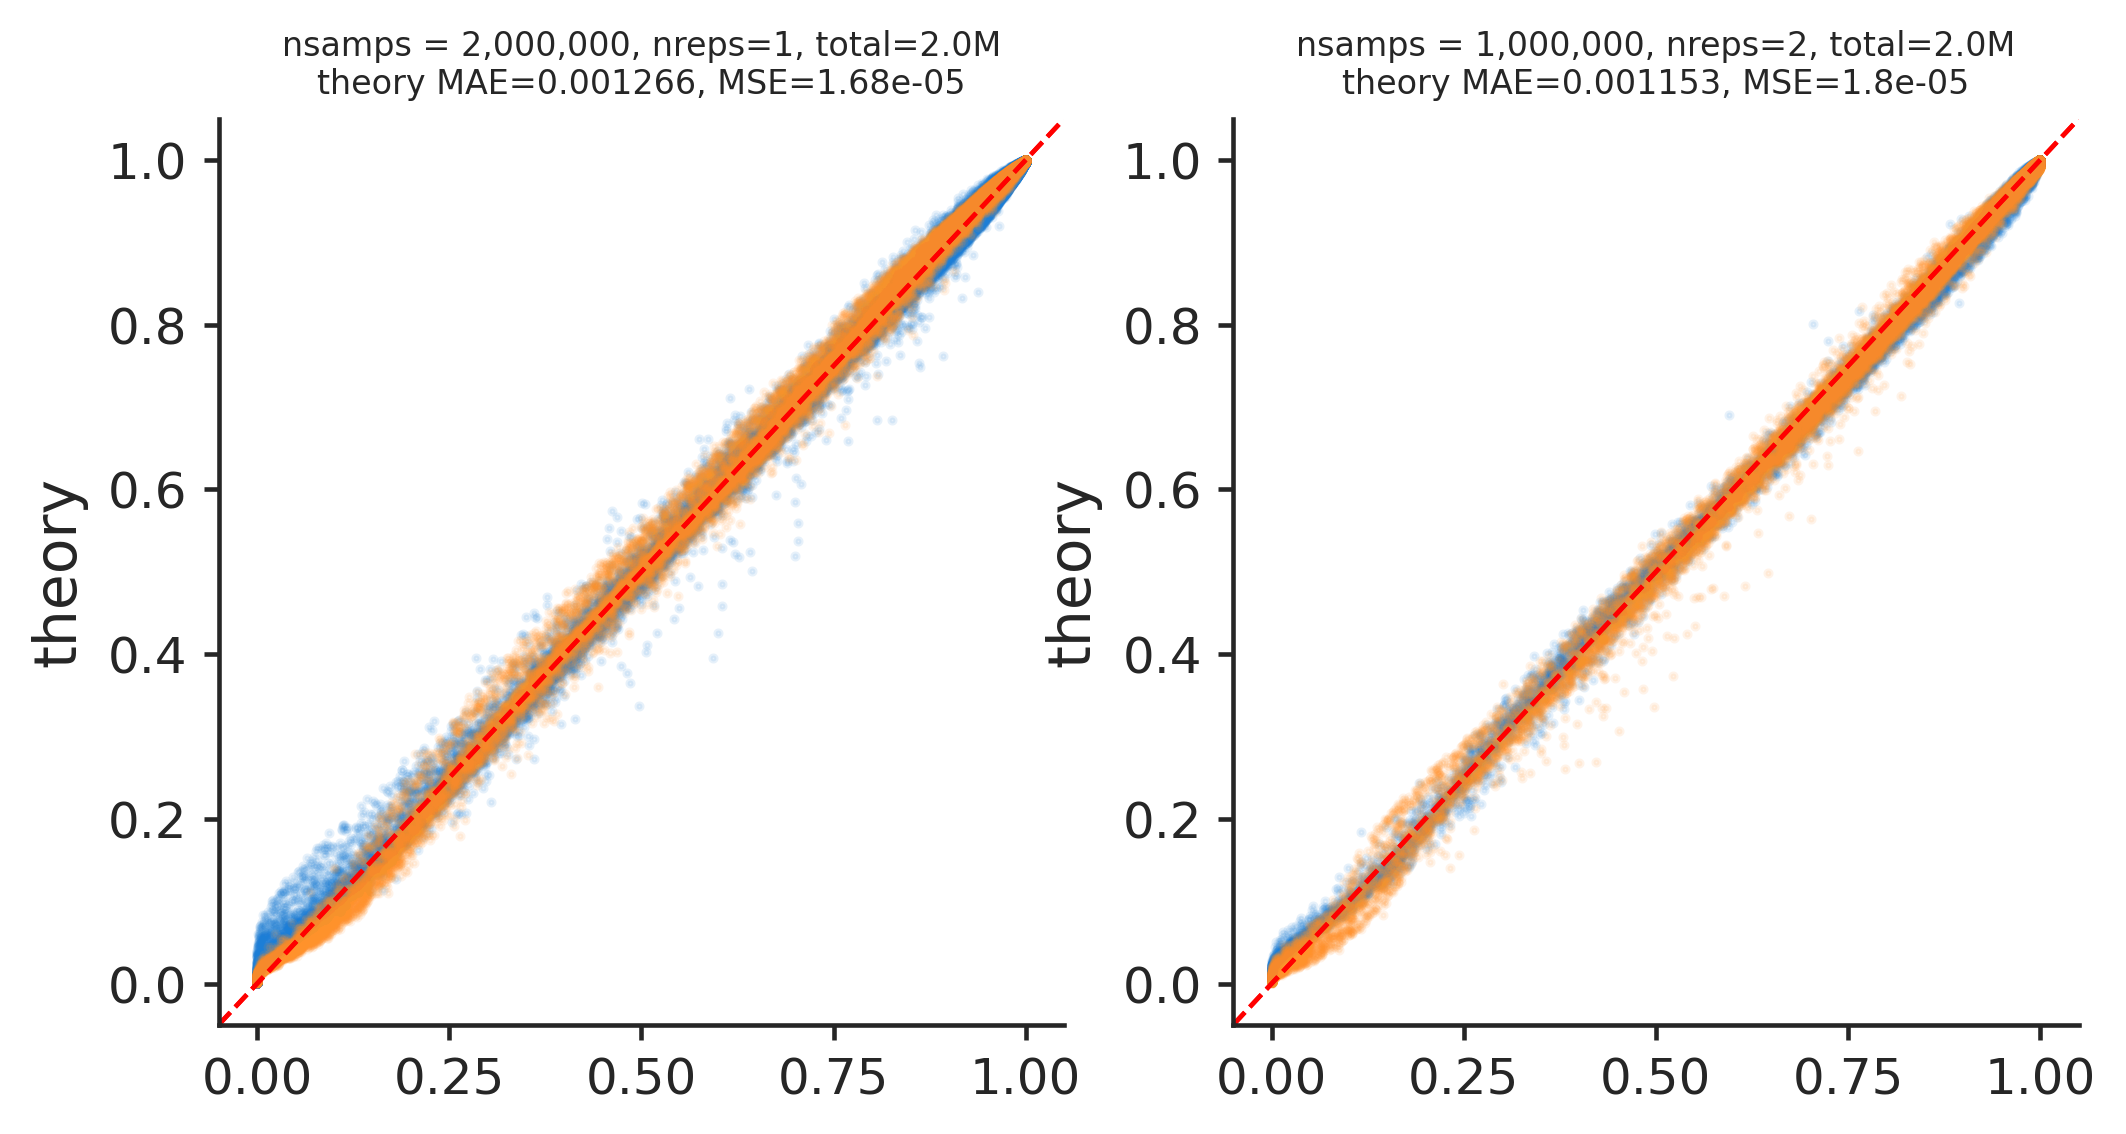

In [57]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ns, nr = 2_000_000, 1
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))

ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))

(<Figure size 2400x1200 with 2 Axes>,
 <AxesSubplot:title={'center':'nsamps = 1,000,000, nreps=2, total=2.0M\ntheory MAE=0.001153, MSE=1.8e-05'}, ylabel='theory'>)

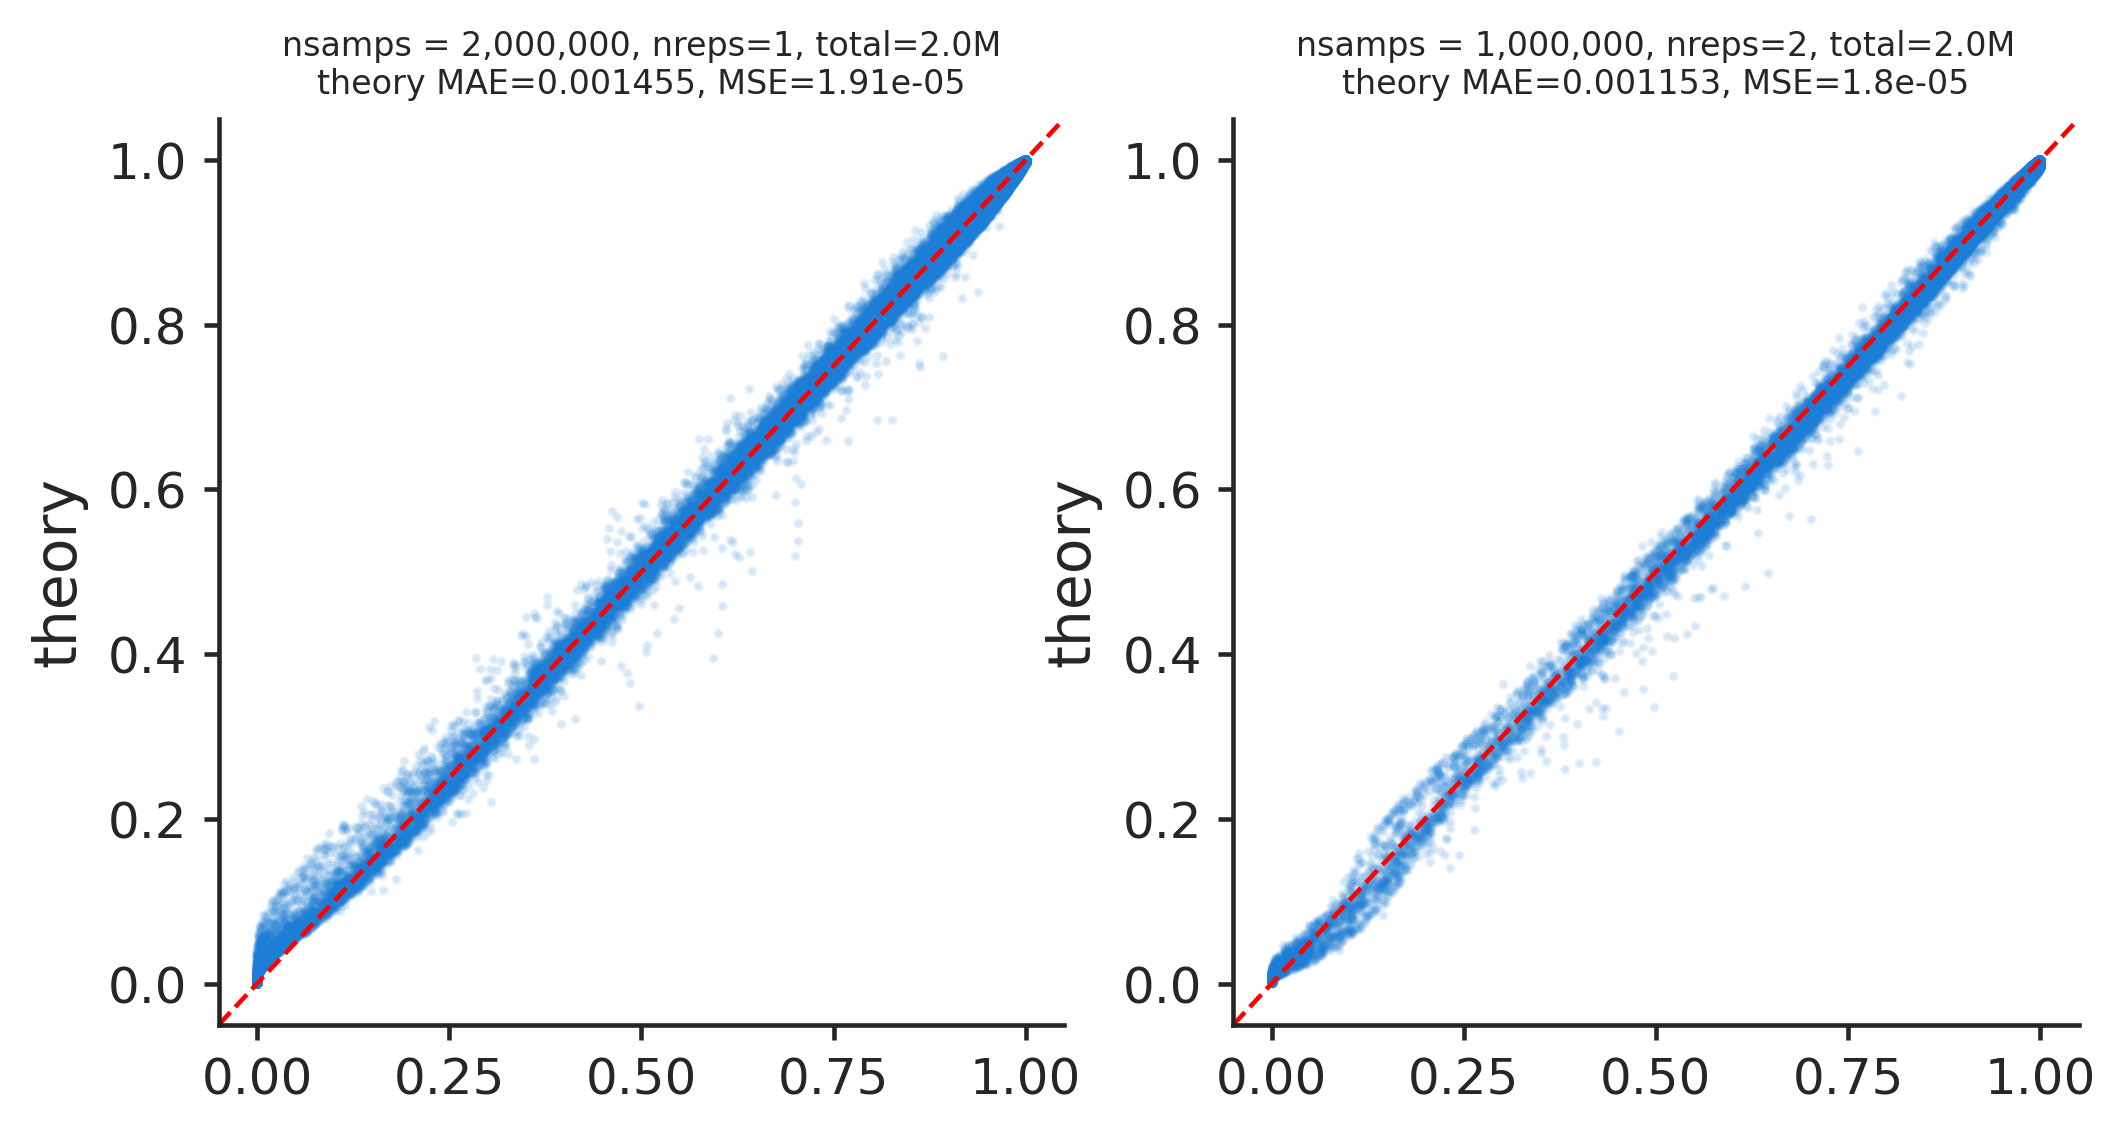

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

# thin params
ns, nr = 2_000_000, 1
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][1]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax1))

ns, nr = 1_000_000, 2
bfunc = res_nsamp[f'varying_nsamples_{ns}_{nr}'][ARCH][0]
theory_loss_plot(bfunc, title=nvary_title(ns, nr), figax=(fig, ax2))


(<Figure size 2400x1200 with 2 Axes>,
 array([<AxesSubplot:xlabel='$\\mu/s$', ylabel='density'>,
        <AxesSubplot:xlabel='$B_\\mathrm{theory}$', ylabel='density'>],
       dtype=object))

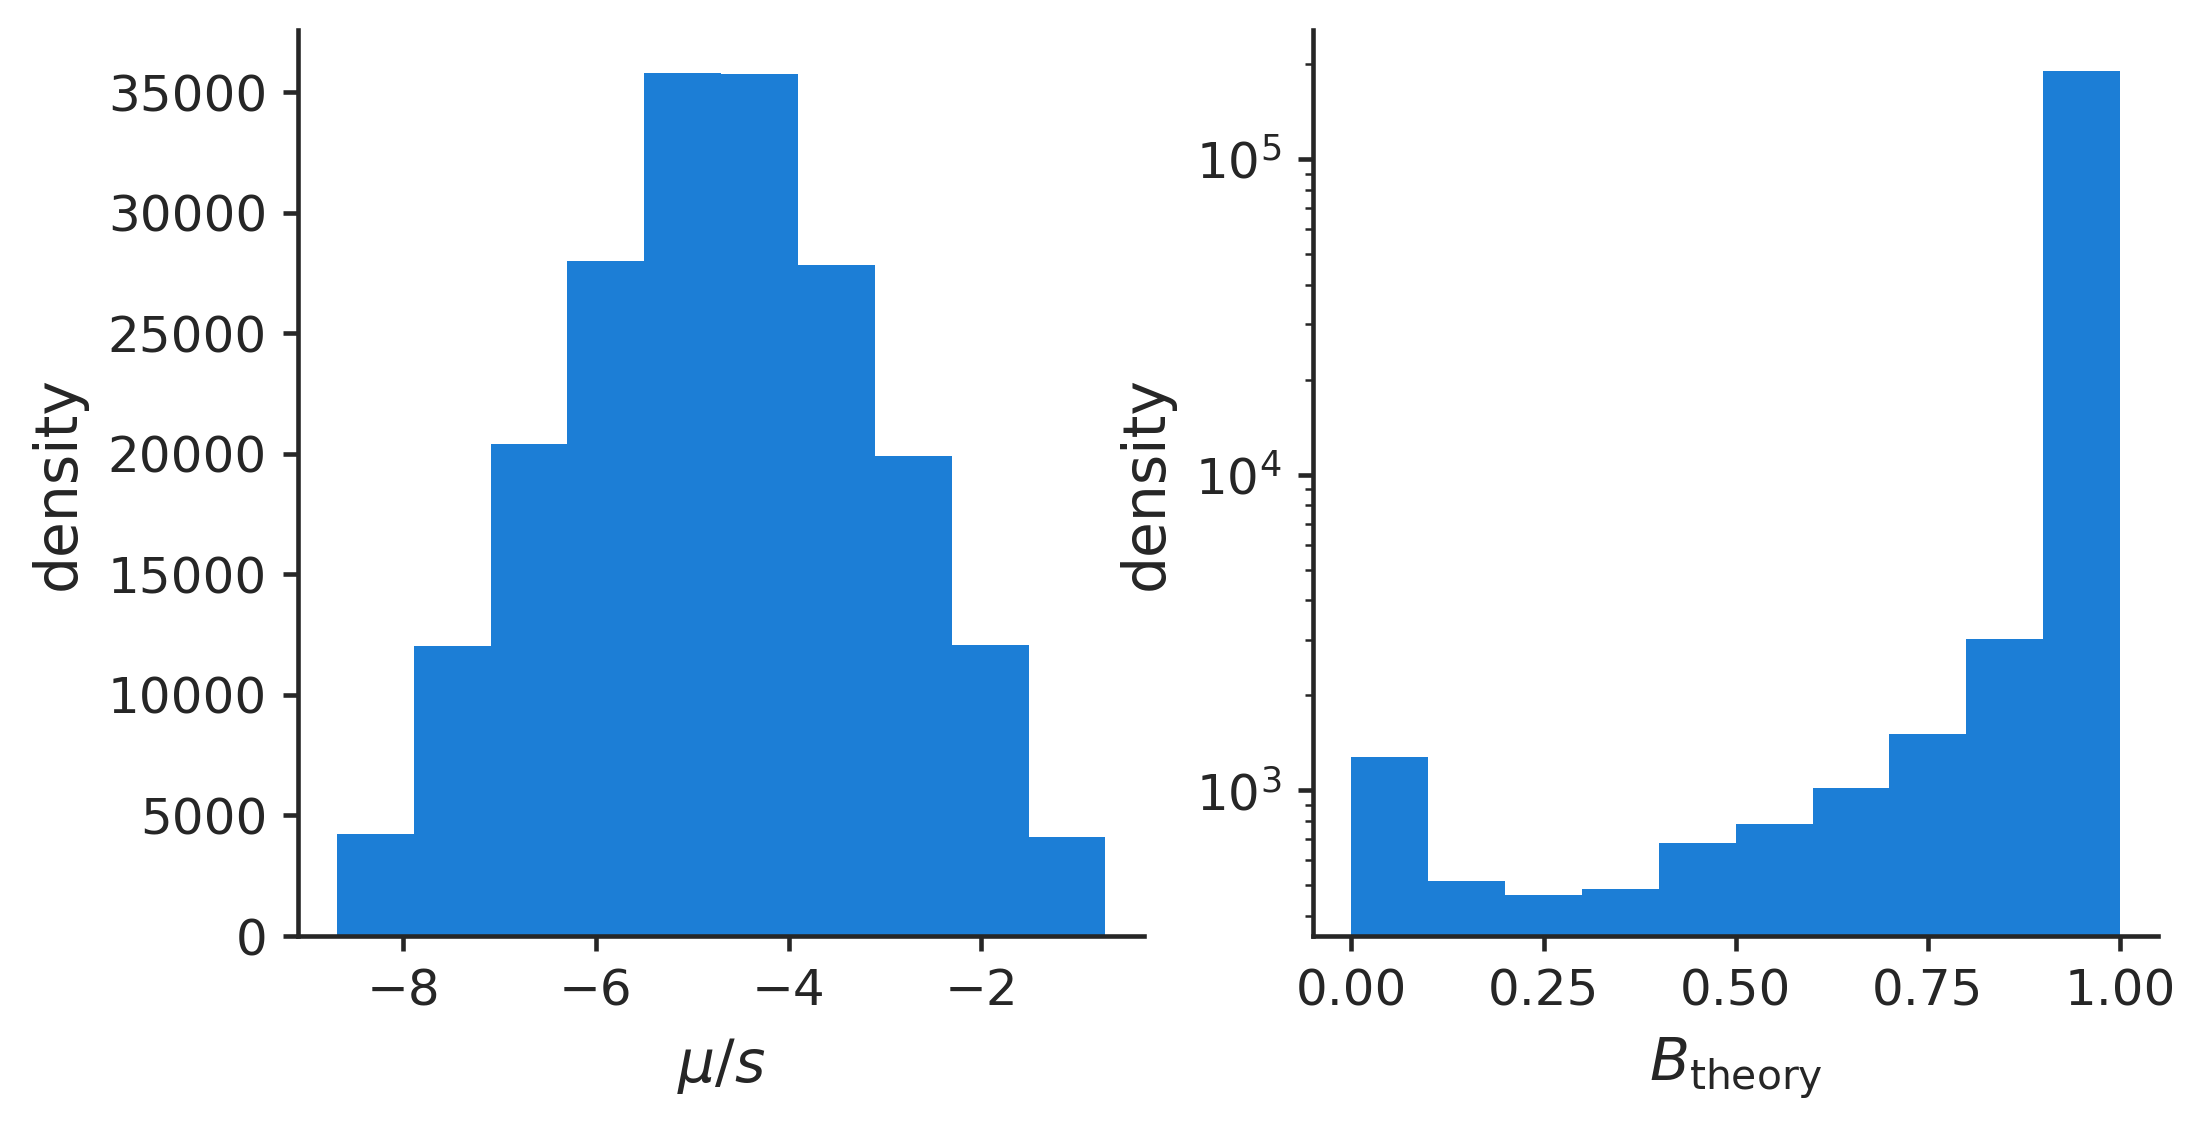

In [55]:
rate_density_plot(bfunc)

### Tables of Theory MAE

#### Unaveraged

In [58]:
# wide params
df['total'] = df['nsamps'] * df['nreps'] / 1e6
df.sort_values('theory_mae').loc[lambda x: x.total <= 5].sort_values('theory_mae').head(10)

nsamps  nreps  theory_mae  predict_mae  total
23   500000     10    0.000884     0.115110    5.0
22   500000     10    0.001034     0.114839    5.0
57  1000000      5    0.001204     0.162056    5.0
56  1000000      5    0.001246     0.161920    5.0
35   500000      5    0.001260     0.161229    2.5
20  2000000      2    0.001431     0.249462    4.0
54  1000000      2    0.001454     0.250356    2.0
55  1000000      2    0.001459     0.250690    2.0
34   500000      5    0.001482     0.161938    2.5
5   1000000      1    0.001513     0.339734    1.0

In [59]:
# narrow params
df['total'] = df['nsamps'] * df['nreps'] / 1e6
df.sort_values('theory_mae').loc[lambda x: x.total <= 5].sort_values('theory_mae').head(10)

nsamps  nreps  theory_mae  predict_mae  total
23   500000     10    0.000884     0.115110    5.0
22   500000     10    0.001034     0.114839    5.0
57  1000000      5    0.001204     0.162056    5.0
56  1000000      5    0.001246     0.161920    5.0
35   500000      5    0.001260     0.161229    2.5
20  2000000      2    0.001431     0.249462    4.0
54  1000000      2    0.001454     0.250356    2.0
55  1000000      2    0.001459     0.250690    2.0
34   500000      5    0.001482     0.161938    2.5
5   1000000      1    0.001513     0.339734    1.0

#### Averaged

Interpret with caution; only two things are being averaged here...

In [60]:
# wide
df.groupby(['nsamps', 'nreps', 'total'])['theory_mae', 'predict_mae'].mean().reset_index().loc[lambda x: x.total <= 5].sort_values('theory_mae').head(20)

/tmp/ipykernel_10056/3927007752.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['nsamps', 'nreps', 'total'])['theory_mae', 'predict_mae'].mean().reset_index().loc[lambda x: x.total <= 5].sort_values('theory_mae').head(20)


nsamps  nreps  total  theory_mae  predict_mae
20   500000     10   5.00    0.000959     0.114975
23  1000000      5   5.00    0.001225     0.161988
19   500000      5   2.50    0.001371     0.161583
22  1000000      2   2.00    0.001456     0.250523
26  2000000      2   4.00    0.001512     0.249216
21  1000000      1   1.00    0.001610     0.339965
25  2000000      1   2.00    0.001720     0.341765
16   100000     10   1.00    0.001839     0.115290
17   500000      1   0.50    0.001963     0.341944
18   500000      2   1.00    0.002081     0.250384
13    50000     10   0.50    0.002303     0.113348
15   100000      5   0.50    0.002325     0.160914
12    50000      5   0.25    0.002810     0.163145
14   100000      2   0.20    0.002925     0.250497
10    10000     10   0.10    0.003432     0.117469
11    50000      1   0.05    0.005045     0.340791
9     10000      5   0.05    0.005510     0.169161
6      5000     10   0.05    0.008005     0.115609
8     10000      2   0.02    0.009812     0.250285
5      5000      2   0.01    0.012429     0.250042

In [61]:
# thin
df.groupby(['nsamps', 'nreps', 'total'])['theory_mae', 'predict_mae'].mean().reset_index().loc[lambda x: x.total <= 5].sort_values('theory_mae').head(20)

/tmp/ipykernel_10056/4041406098.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['nsamps', 'nreps', 'total'])['theory_mae', 'predict_mae'].mean().reset_index().loc[lambda x: x.total <= 5].sort_values('theory_mae').head(20)


nsamps  nreps  total  theory_mae  predict_mae
20   500000     10   5.00    0.000959     0.114975
23  1000000      5   5.00    0.001225     0.161988
19   500000      5   2.50    0.001371     0.161583
22  1000000      2   2.00    0.001456     0.250523
26  2000000      2   4.00    0.001512     0.249216
21  1000000      1   1.00    0.001610     0.339965
25  2000000      1   2.00    0.001720     0.341765
16   100000     10   1.00    0.001839     0.115290
17   500000      1   0.50    0.001963     0.341944
18   500000      2   1.00    0.002081     0.250384
13    50000     10   0.50    0.002303     0.113348
15   100000      5   0.50    0.002325     0.160914
12    50000      5   0.25    0.002810     0.163145
14   100000      2   0.20    0.002925     0.250497
10    10000     10   0.10    0.003432     0.117469
11    50000      1   0.05    0.005045     0.340791
9     10000      5   0.05    0.005510     0.169161
6      5000     10   0.05    0.008005     0.115609
8     10000      2   0.02    0.009812     0.250285
5      5000      2   0.01    0.012429     0.250042

How does varying number of samples/replicates impact bias

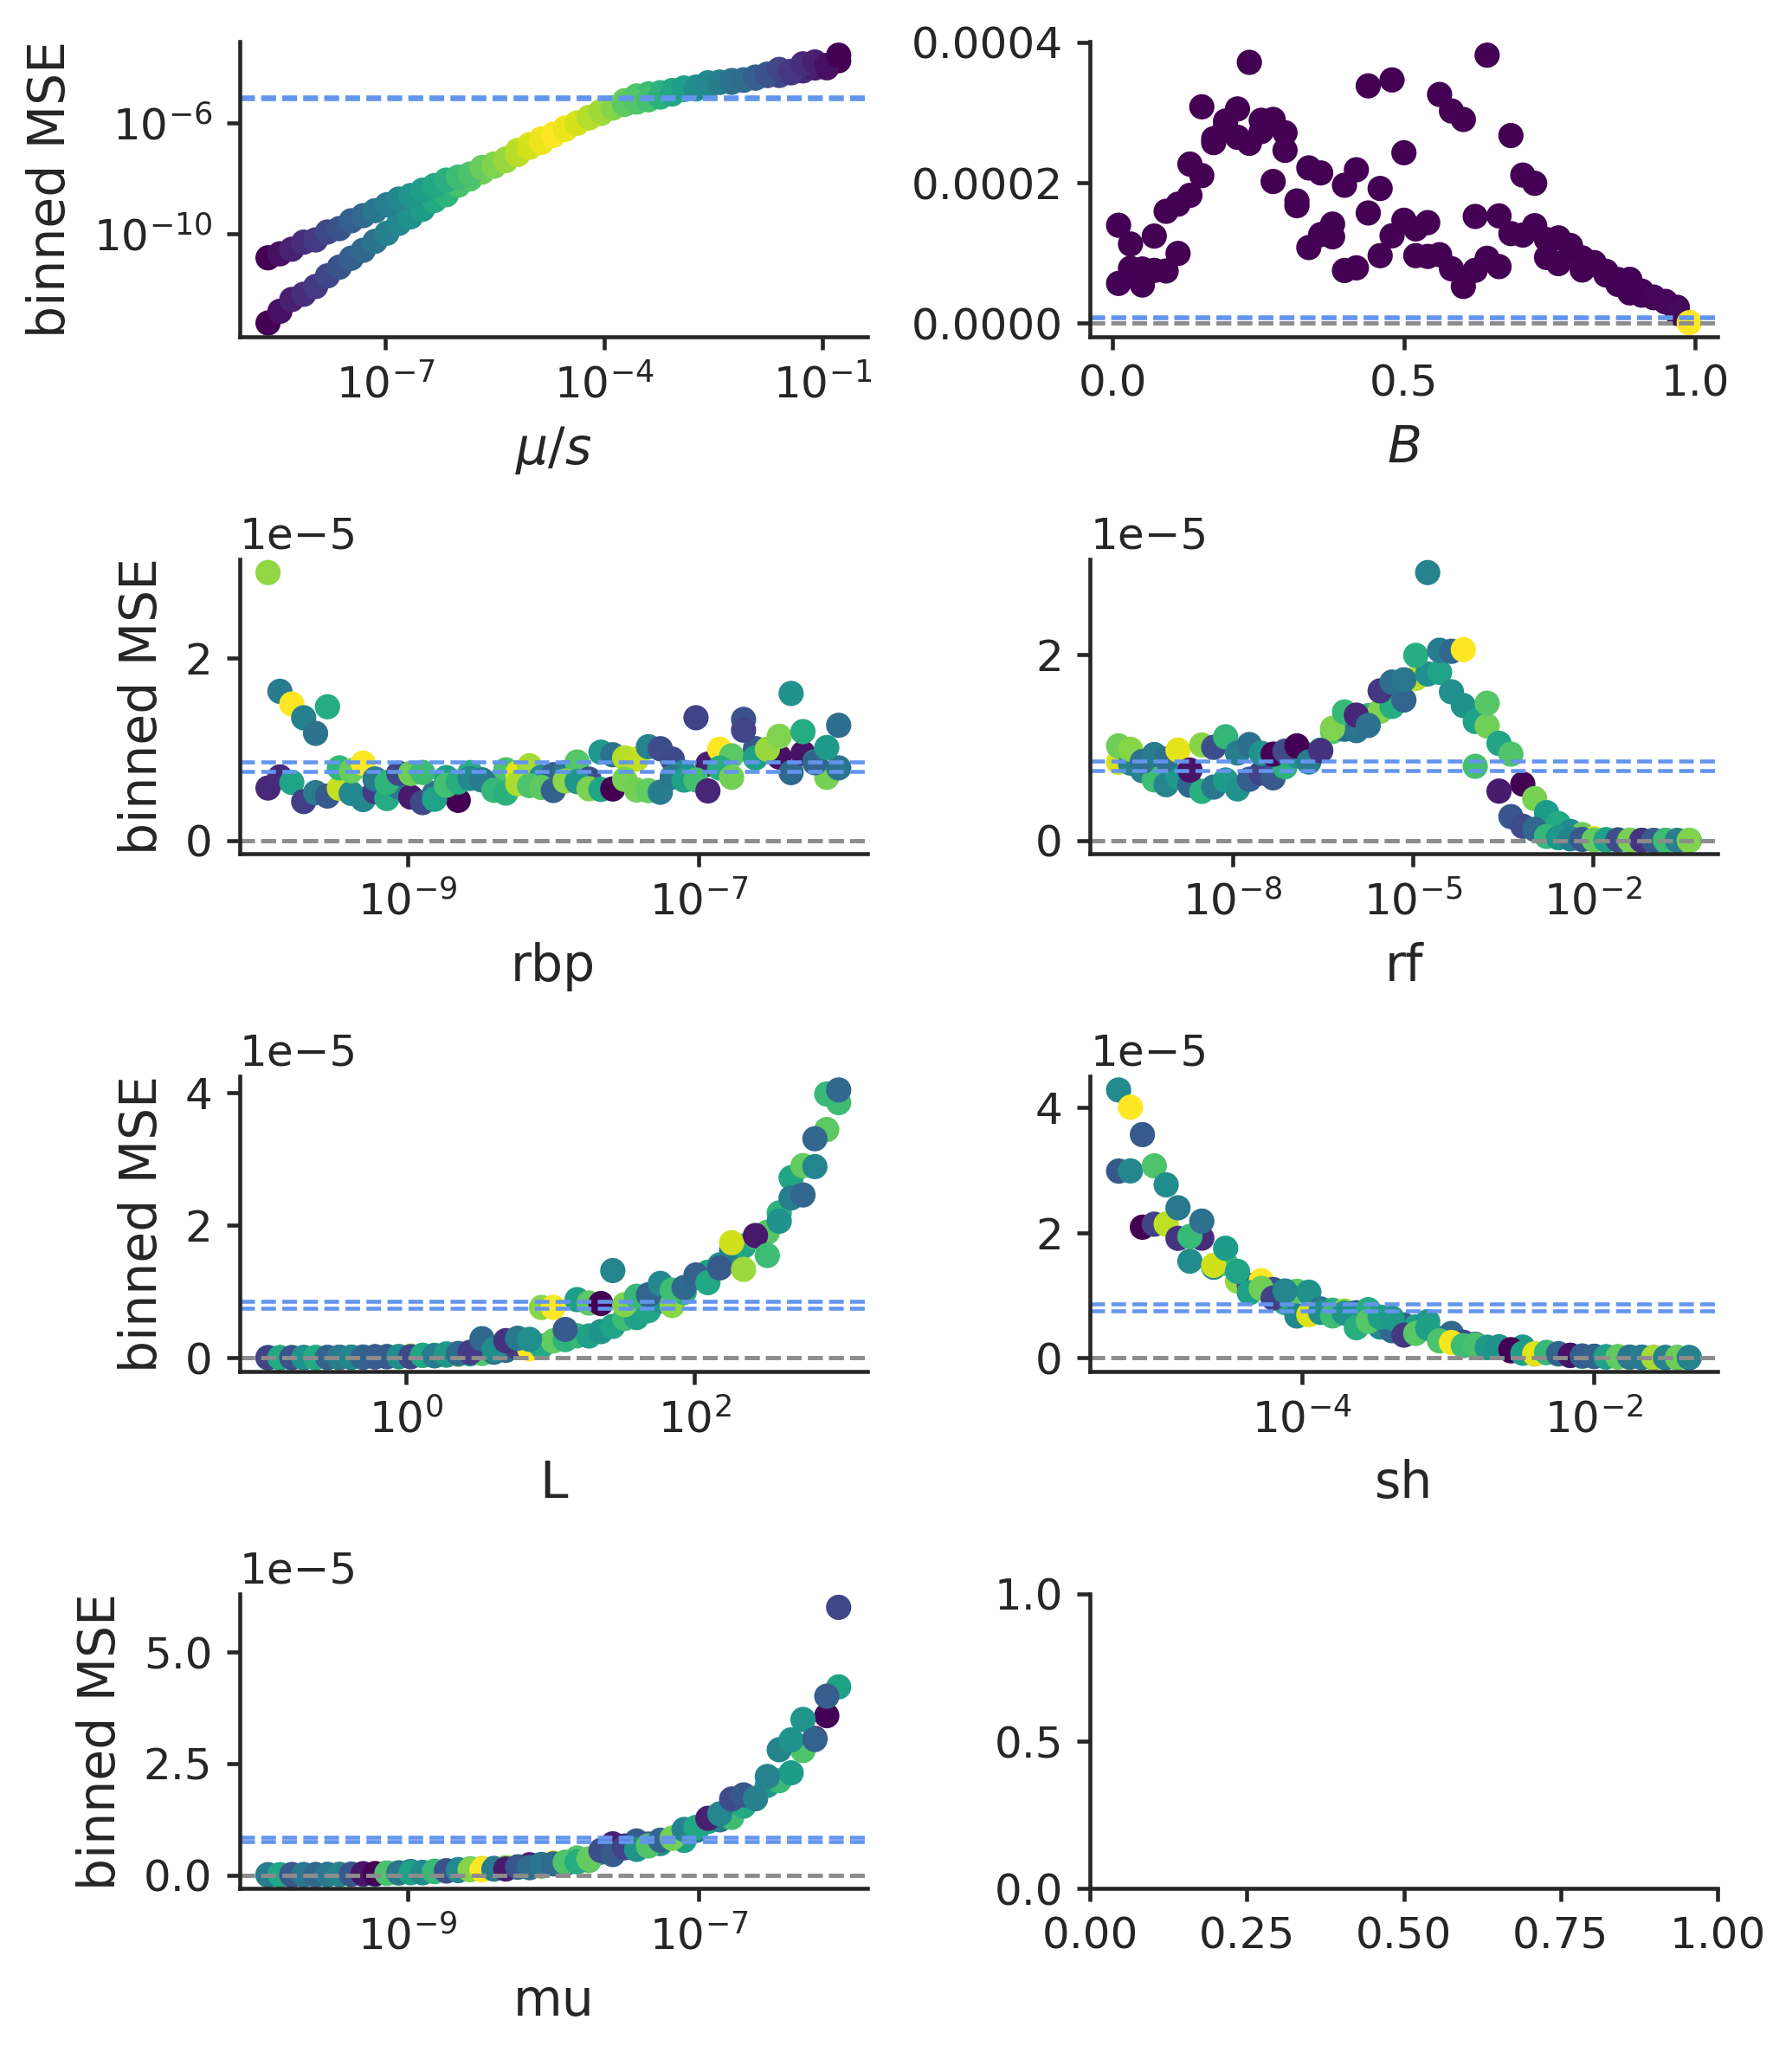

In [62]:
nsamps, nreps = 1_000_000, 5

figax = None
for i in range(2):
    bf = res_nsamp[f'varying_nsamples_{nsamps}_{nreps}'][ARCH][i]
    figax = feature_loss_plots(bf, 50, loss='mse', figax=figax)

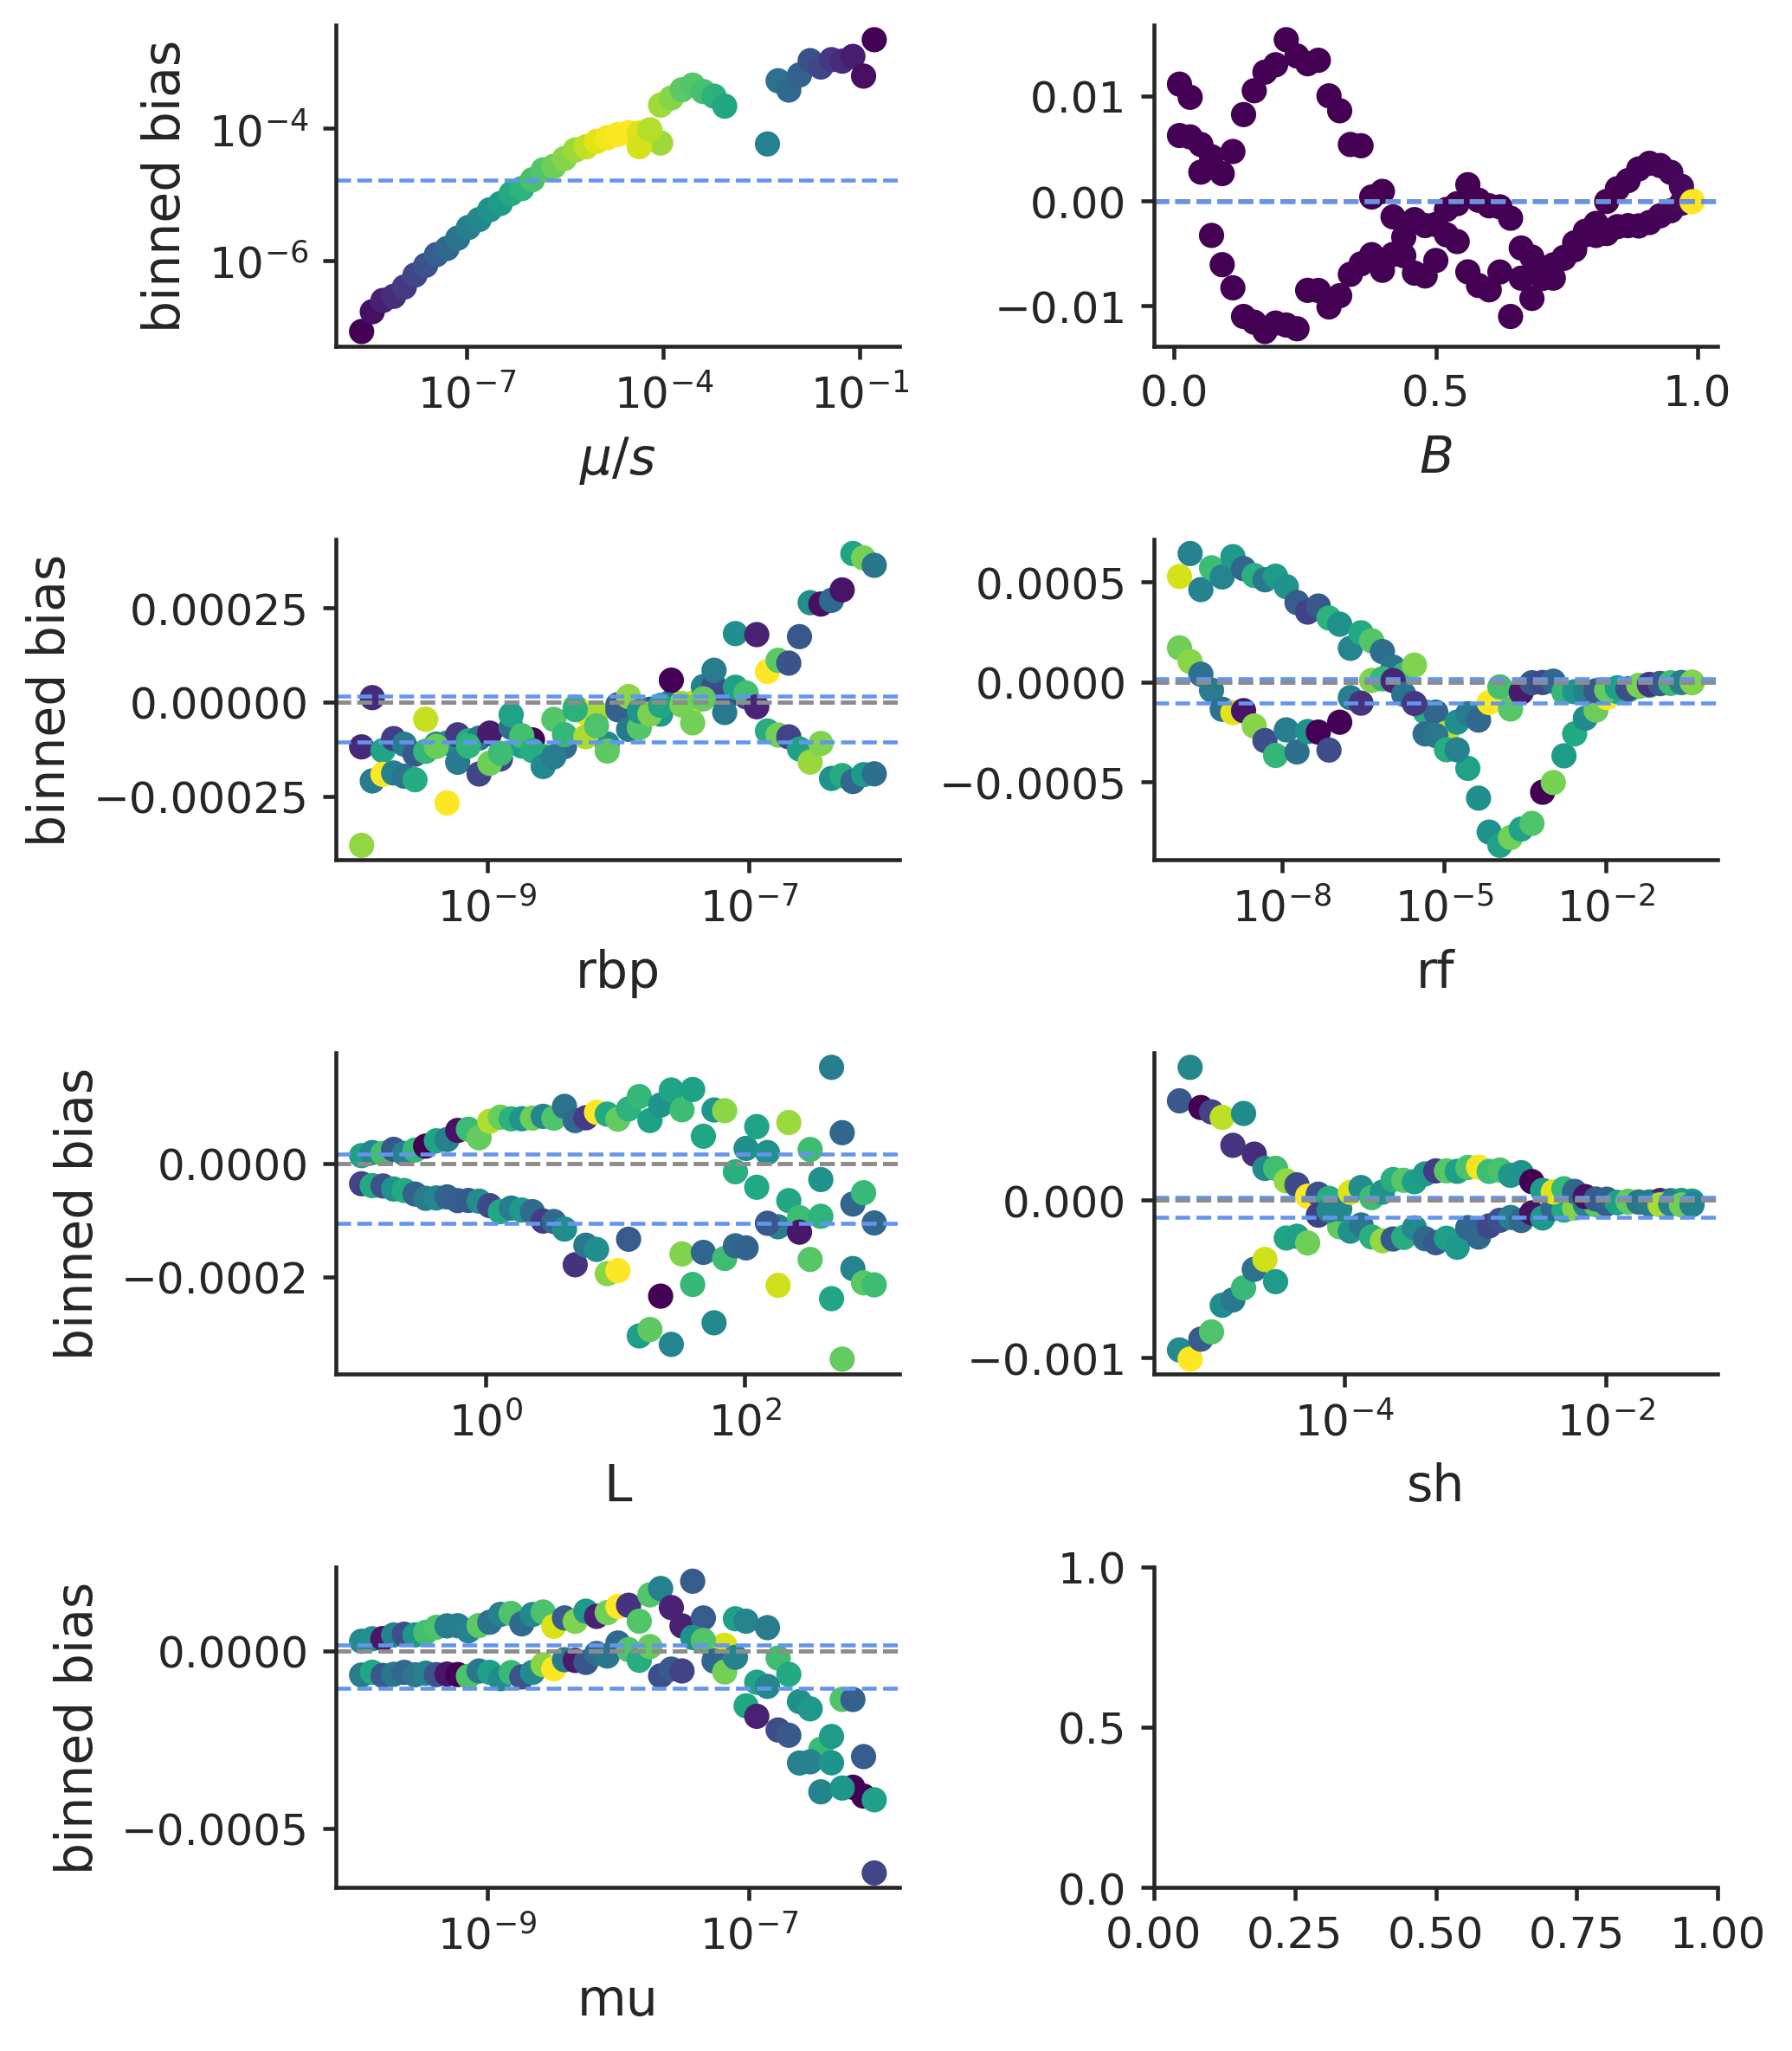

In [63]:
nsamps, nreps = 1_000_000, 5

figax = None
for i in range(2):
    bf = res_nsamp[f'varying_nsamples_{nsamps}_{nreps}'][ARCH][i]
    figax = feature_loss_plots(bf, 50, loss='bias', figax=figax)

## Segment BGS Model

$$B_\mathrm{seg} = \exp\left(\int_0^L \frac{dl}{t(1+(1-t)(c + r_\text{BP}l)/t)^2}\right) = \exp\left(\frac{r_\text{BP} L t}{(c  (1-t)+t) ((1-t) r_\text{BP} L +t + c (1 - t))} \right)$$

where $c$ is the recombination fraction between the focal neutral site and the start of the segment with length $L$.

### With Everything on a Log-scale

Slightly reduced paramter space — `rf` goes only to $10^{-3}$.

In [ ]:
bgs_segment(1e-8, 1e-1, 1000, 1e-8, 1e-4)

In [ ]:
res['segment_logL_logrbp_logrf'][ARCH][0].func

In [ ]:
arch_loss_plot(res['segment_logL_logrbp_logrf'])

In [ ]:
ARCH = (0, 0, 0, 0, 2)

b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf'][ARCH][0], n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

Some little experiments to get a sense of scales, etc.

In [ ]:
rf = 10**np.linspace(-10, np.log10(0.5), 100)
plt.plot(rf, bgs_segment(1e-8, 1e-2, 1000, 1e-8, rf))
plt.plot(rf, bgs_segment(1e-7, 1e-2, 1000, 1e-8, rf))
plt.plot(rf, bgs_segment(1e-7, 1e-3, 1000, 1e-8, rf))

plt.axhline(1)
plt.semilogx()

In [ ]:
res['segment_logL_logrbp_logrf'][ARCH][0].func

## TODO

In [ ]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
bs = []
ys = []
func = res['segment_logL_logrbp_logrf'][ARCH][0].func
for sh in np.logspace(-5, -1,  20):
    (mu_grid_rbp, s_grid_rbp, a, b, c), X_mesh_orig_rbp, X_mesh_rbp, predict_grid_rbp = func.predict_grid({'rf': 100},
                                                                            fix_X={'mu': 1e-5, 
                                                                                   'sh': np.log10(sh),
                                                                                   'rbp': 1e-8,
                                                                                    'L': 1_000})
    bs.append(a)
    ys.append(predict_grid_rbp)


In [ ]:
func.predict_grid({'rf': 100},fix_X={'mu': 1e-5, 'sh': np.log10(sh),'rbp': 1e-8,'L': 1_000})

In [ ]:
cmap = cm.viridis(np.linspace(0, 1, 20))
for i, y in enumerate(ys):
    plt.plot(np.log10(bs[0]), y.squeeze(), c=cmap[i])

In [ ]:
rate_density_plot(res['segment_logL_logrbp_logrf'][ARCH][0])

### Wide Parameter Range — Log Scale Parameters

In [ ]:
ARCH = (0, 0, 0, 0, 2)

In [ ]:
arch_loss_plot(res['segment_logL_logrbp_logrf_wide'])

In [ ]:
res['segment_logL_logrbp_logrf_wide'][ARCH][0].func.test_mae()

In [ ]:
res['segment_logL_logrbp_logrf_wide'][ARCH][0].theory_loss()

In [ ]:
res['segment_logL_logrbp_logrf_wide'][ARCH][0].func.X_test_raw

In [ ]:
theory_loss_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][0])

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][0], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][1], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
def ensemble(bfuncs, X):
    predicts = []
    assert len(set([tuple(bf.func.features) for bf in bfuncs])) == 1, "mismatching feature!"
    for bf in bfuncs:
        predicts.append(bf.func.predict(X))
    return np.array(predicts).squeeze().mean(axis=0)

Xt = res['segment_logL_logrbp_logrf_wide'][ARCH][0].func.X_test_raw
Xt

In [ ]:
a = ensemble(res['segment_logL_logrbp_logrf_wide'][ARCH], Xt)

In [ ]:
b = res['segment_logL_logrbp_logrf_wide'][ARCH][0].theory_B(Xt)

In [ ]:
plt.scatter(b, a, alpha=0.1, s=2)
plt.axline((0, 0), slope=1, c='r', linestyle='dashed')
print(np.mean(np.abs(a-b)))

In [ ]:
theory_loss_plot(res['segment_logL_logrbp_logrf_wide'][ARCH][0])

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide'][ARCH][i], 50, loss='bias', figax=figax)

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide'][ARCH][i], 50, loss='mae', figax=figax)

### Rejection Sampling Test

#### Unreplicated Rejection Sampling

In [ ]:
arch_loss_plot(res['segment_logL_logrbp_logrf_wide_reject'])

Interestingly, target rejection sampling (so the target's theoretic B is Uniform, based on theory — this won't be possible to know with the weak selection BGS) does lower loess, but doesn't seem to help out with theory MAE (I've looked at both reps; they're similar):

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][1], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
reject_mae = [res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].theory_loss(),
              res['segment_logL_logrbp_logrf_wide_reject'][ARCH][1].theory_loss()]
standard_mae = [res['segment_logL_logrbp_logrf_wide'][ARCH][0].theory_loss(),
              res['segment_logL_logrbp_logrf_wide'][ARCH][1].theory_loss()]
                            

In [ ]:
np.mean(reject_mae), np.mean(standard_mae)

Check the empirical B distribution — indeed it's flat between 0 and 1:

In [ ]:
_ = plt.hist(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].theory_B(), 80)

In [ ]:
Xcols = res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].func.col_indexer()
_ = plt.hist(np.log10(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].func.X_test_orig_linear[:, Xcols('mu')]/res['segment_logL_logrbp_logrf_wide_reject'][ARCH][0].func.X_test_orig_linear[:, Xcols('sh')]), 80)

Interestingly, the bias is flatter now:

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][i], 50, loss='bias', figax=figax)

In [ ]:
figax = None
for i in range(2):
    figax = feature_loss_plots(res['segment_logL_logrbp_logrf_wide_reject'][ARCH][i], 50, loss='mae', figax=figax)

#### Replicated Rejection Sampling

In [ ]:
ARCH = (0, 0, 0, 0, 2)
b_learn_diagnostic_plot(res['segment_logL_logrbp_logrf_wide_reject_replicated'][ARCH][0], 
                        n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

In [ ]:
figax = None
for i in range(2):
    bf = res['segment_logL_logrbp_logrf_wide_reject_replicated'][ARCH][1]
    figax = feature_loss_plots(bf, 50, loss='bias', figax=figax)

## Time Estimation

In [99]:
def time_estimation(total_sims, ncores=1, sec_per_sim = 10):
    min_per_sec = 1/60
    hour_per_min = 1/60
    day_per_hour = 1/24
    return total_sims * sec_per_sim * min_per_sec * hour_per_min * day_per_hour 

def time(total_sims, ncores):
    time = time_estimation(total_sims)
    print(f"{np.round(total_sims/1e6, 2)}M sims total will take ~{np.round(time/ncores, 2)} days, across {ncores} cores")

time(5e6, 500)
time(5e6, 70)
time(5e6, 1)

5.0M sims total will take ~1.16 days, across 500 cores
5.0M sims total will take ~8.27 days, across 70 cores
5.0M sims total will take ~578.7 days, across 1 cores
